# Project Census WFH   
The goal of this workbook is to compare the efficacy of machine learning models based on different levels of spacial consolidation, based on the [Australian Statistical Geography Standard](https://www.abs.gov.au/websitedbs/D3310114.nsf/home/Australian+Statistical+Geography+Standard+(ASGS)) framework. the key questions are:   

- Can we find a model for predicting with an R2 value > 0.7? (Based on [prior work](https://github.com/blkemp/ABS-Region-Data/tree/BKSubmission), I suspect the answer is yes).
- Using this model, what is the impact on accuracy for feeding in data that is consolidated at a different level (e.g. neighborhood vs city vs county)?
- How do models trained at differing levels of granularity compare in both baseline accuracy and generalisability? I.e. Are models trained with the most fine grained data more accurate, or are they prone to overfitting?

As a starting point I will be utilising the [Australian Bureau of Statistics 2016 Census Datapacks](https://datapacks.censusdata.abs.gov.au/datapacks/) and attempting to predict "working from home" behaviours by region. Why this particular response vector? a) It just seems interesting and b) I suspect that demographic information available within the census itself (gender, age, profession and industry) will all be strongly related to both individuals' propensity to undertake working from home and their ability to do so with support from employers.

In [35]:
# Import statements
# Declare Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import os
import pickle
from textwrap import wrap
import operator
import au_census_analysis_functions as cnss_func

# Set a variable for current notebook's path for various loading/saving mechanisms
nb_path = os.getcwd()

In [36]:
import importlib
importlib.reload(cnss_func)

<module 'au_census_analysis_functions' from 'C:\\Users\\kempbri\\OneDrive - Mars Inc\\Documents\\GitHub\\Census-ASGS-Level-and-Model-Sensitivity\\au_census_analysis_functions.py'>

In [3]:
# Show tables which have the above fields of information available
df_meta = pd.read_csv('{}\Data\Metadata\Metadata_2016_refined.csv'.format(nb_path))
df_m_refined = df_meta[(df_meta['Age'] > 0) |
                      (df_meta['Income'] > 0) |
                      (df_meta['Occupation'] > 0) |
                      (df_meta['Family Composition'] > 0) |
                      (df_meta['Internet status'] > 0) |
                      (df_meta['Building occupation status'] > 0) |
                      (df_meta['Number of Bedrooms'] > 0) |
                      (df_meta['Place of Birth'] > 0) |
                      (df_meta['Country of Birth of Parents'] > 0) |
                      (df_meta['Year of Arrival'] > 0)]
tables_to_load = df_m_refined['Profile table'].unique().tolist()
load_features = ['Age','Income','Occupation',
                 'Family Composition','Internet status',
                 'Building occupation status','Number of Bedrooms',
                 'Place of Birth','Country of Birth of Parents','Year of Arrival']

In [4]:
# build a pipelines to fill NaNs with medians
#note to self, it may be interesting to explore the functionality of IUterativeImputer instead of SimpleImputer
def build_model():
    ''' Impute for missing values and build a model to complete a quick
    Grid search over RandomForestRegressor key parameters.
    '''
    pipeline_model = Pipeline([
        ('impute', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('clf', RandomForestRegressor(n_estimators=100, random_state=42, max_depth=100))
    ])
    # specify parameters for grid search
    parameters = {'clf__n_estimators':[20,40], # this used to start at 10 and go to 80 but was a huge timesuck and not improving performance
              'clf__max_depth':[16,32,64], # this used to go to 128 but had no impact on performance
              #'clf__min_samples_leaf':[1,2,4] This wasn't really having an impact on performance
             }

    # create grid search object
    scorer = make_scorer(r2_score)
    cv = GridSearchCV(pipeline_model, param_grid=parameters, scoring=scorer, verbose = 3)

    return cv

In [5]:
def model_WFH(stat_a_level):
    # Load table 59 (the one with commute mechanism) and have a quick look at the distribution of WFH by sex
    df_travel = cnss_func.load_table_refined('G59', ['Number of Commuting Methods'], statistical_area_code=stat_a_level)
    cols_to_delete = [x for x in df_travel.columns if 'Worked_at_home' not in x]
    df_travel.drop(cols_to_delete,axis=1, inplace=True)

    df_pop = cnss_func.load_census_csv(['G01'], statistical_area_code=stat_a_level)
    df_pop.set_index(df_pop.columns[0], inplace=True)
    df_pop = df_pop.drop([x for x in df_pop.columns if 'Tot_P_P' not in x], axis=1)
    df_travel = df_travel.merge(df_pop, left_index=True, right_index=True)
    
    # Create new "Work From Home Participation Rate" vector to ensure consistency across regions
    # Base this off population who worked from home divided by total population in the region
    df_travel['WFH_Participaction'] = (df_travel['Method of Travel to Work by Sex|Worked_at_home']/
                                       df_travel['Tot_P_P'])
    # Drop the original absolute values column
    df_travel = df_travel.drop(['Method of Travel to Work by Sex|Worked_at_home'], axis=1)
    
    # load input vectors
    load_tables = tables_to_load
    load_features = ['Age','Income','Occupation',
                     'Family Composition','Internet status',
                     'Building occupation status','Number of Bedrooms',
                     'Place of Birth','Country of Birth of Parents','Year of Arrival']
    
    input_vectors = cnss_func.load_tables_specify_cats(load_tables, load_features, statistical_area_code=stat_a_level)
    
    # Remove duplicate column values
    input_vectors = input_vectors.T.drop_duplicates().T

    # Bring in total population field and scale all the values by this item
    input_vectors = input_vectors.merge(df_pop, left_index=True, right_index=True)

    # convert input features to numeric
    cols = input_vectors.columns
    input_vectors[cols] = input_vectors[cols].apply(pd.to_numeric, errors='coerce')

    # Drop rows with zero population
    input_vectors = input_vectors.dropna(subset=['Tot_P_P'])
    input_vectors = input_vectors[input_vectors['Tot_P_P'] > 0]

    # Scale all factors by total region population
    for cols in input_vectors.columns:
        if 'Tot_P_P' not in cols:
            input_vectors[cols] = input_vectors[cols]/input_vectors['Tot_P_P']

    # merge and drop na values from the response vector
    df_travel = df_travel.merge(input_vectors, left_index=True, right_index=True)
    df_travel = df_travel.dropna(subset=['WFH_Participaction'])

    df_travel = df_travel.drop([x for x in df_travel.columns if 'Tot_P_P' in x], axis=1)

    # Remove duplicate column values
    df_travel = df_travel.T.drop_duplicates().T

    # Investigate correlations to check out items which stand out as potential drivers
    response_vector = 'WFH_Participaction'

    # Create X & y
    X = df_travel.drop(response_vector, axis=1)
    y = df_travel[response_vector]

    # Split the 'features' and 'response' vectors into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    # build a model using all the above inputs
    grid_obj = build_model()

    # TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator
    return grid_fit.best_estimator_, X_train, X_test, y_train, y_test, X

In [6]:
def model_analyse_pred(X_test, y_test, model):
    preds = model.predict(X_test)
    lineStart = min(preds.min(), y_test.min())  
    lineEnd = max(preds.max()*1.2, y_test.max()*1.2)

    print('R2 Score:{}'.format(r2_score(preds, y_test)))

    plt.figure()
    plt.scatter(preds, y_test, color = 'k', alpha=0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
    plt.xlim(lineStart, lineEnd)
    plt.ylim(lineStart, lineEnd)
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.show()

In [7]:
# Load table 59 (the one with commute mechanism)
df_response = cnss_func.load_table_refined('G59', ['Number of Commuting Methods'], statistical_area_code='SA3')
cols_to_delete = [x for x in df_response.columns if 'Worked_at_home' not in x]
df_response.drop(cols_to_delete,axis=1, inplace=True)

df_pop = cnss_func.load_census_csv(['G01'], statistical_area_code='SA3')
df_pop.set_index(df_pop.columns[0], inplace=True)
df_pop = df_pop.drop([x for x in df_pop.columns if 'Tot_P_P' not in x], axis=1)
df_response = df_response.merge(df_pop, left_index=True, right_index=True)

# Create new "Work From Home Participation Rate" vector to ensure consistency across regions
# Base this off population who worked from home divided by total population in the region
df_response['WFH_Participation'] = (df_response['Method of Travel to Work by Sex|Worked_at_home']/
                                     df_response['Tot_P_P'])
# Drop the original absolute values column
df_response = df_response.drop(['Method of Travel to Work by Sex|Worked_at_home'], axis=1)
df_response = df_response.drop(['Tot_P_P'], axis=1)
df_response.head()

,WFH_Participation
10102,0.019780
10103,0.040122
10104,0.025312
10105,0.027954
10106,0.039619


In [8]:
# Load table 59 (the one with commute mechanism)
df_response_sa2 = cnss_func.load_table_refined('G59', ['Number of Commuting Methods'], statistical_area_code='SA2')
cols_to_delete = [x for x in df_response_sa2.columns if 'Worked_at_home' not in x]
df_response_sa2.drop(cols_to_delete,axis=1, inplace=True)

df_pop_sa2 = cnss_func.load_census_csv(['G01'], statistical_area_code='SA2')
df_pop_sa2.set_index(df_pop_sa2.columns[0], inplace=True)
df_pop_sa2 = df_pop_sa2.drop([x for x in df_pop_sa2.columns if 'Tot_P_P' not in x], axis=1)
df_response_sa2 = df_response_sa2.merge(df_pop_sa2, left_index=True, right_index=True)

# Create new "Work From Home Participation Rate" vector to ensure consistency across regions
# Base this off population who worked from home divided by total population in the region
df_response_sa2['WFH_Participation'] = (df_response_sa2['Method of Travel to Work by Sex|Worked_at_home']/
                                         df_response_sa2['Tot_P_P'])
# Drop the original absolute values column
df_response_sa2 = df_response_sa2.drop(['Method of Travel to Work by Sex|Worked_at_home'], axis=1)
df_response_sa2 = df_response_sa2.drop(['Tot_P_P'], axis=1)

df_zero_area = pd.read_csv('{}\Data\Metadata\Zero_Area_Territories.csv'.format(os.getcwd()))
zero_indicies = set(df_zero_area['AGSS_Code_2016'].tolist())
zero_indicies_drop = set(df_response_sa2.index.values).intersection(zero_indicies)
df_response_sa2 = df_response_sa2.drop(zero_indicies_drop, axis=0)
df_response_sa2.head()

,WFH_Participation
101021007,0.057593
101021008,0.009094
101021009,0.009316
101021010,0.014208
101021011,0.029978


In [9]:
df_response_sa3 = df_response
df_response_sa3.describe()

,WFH_Participation
count,340.000000
mean,0.024045
std,0.010998
min,0.000000
25%,0.015899
50%,0.022771
75%,0.030529
max,0.072937


In [10]:
df_response_sa2.describe()

,WFH_Participation
count,2255.000000
mean,0.025174
std,0.032388
min,0.000000
25%,0.012418
50%,0.019159
75%,0.030622
max,1.000000


## Begin importing and exploring data

In [4]:
# Import metadata sheets
df_meta_tables = pd.read_excel('{}\Data\Metadata\Metadata_2016_GCP_DataPack.xlsx'.format(nb_path),
                               sheet_name = 'Table number, name, population',
                               skiprows=9)
df_meta_measures = pd.read_excel('{}\Data\Metadata\Metadata_2016_GCP_DataPack.xlsx'.format(nb_path),
                               sheet_name = 'Cell descriptors information',
                               skiprows=10)

In [5]:
df_meta_tables.tail()

,Table number,Table name,Table population
54,G55,Total Family Income (Weekly) by Labour Force S...,Couple families with children
55,G56,Total Family Income (Weekly) by Labour Force S...,One parent families
56,G57,Occupation by Age by Sex,Employed persons aged 15 years and over
57,G58,Occupation by Hours Worked by Sex,Employed persons aged 15 years and over
58,G59,Method of Travel to Work by Sex,Employed persons aged 15 years and over


In [6]:
df_meta_measures['Table number'] = df_meta_measures['DataPack file'].str[:3]

In [7]:
df_meta_measures = pd.merge(df_meta_measures, df_meta_tables, on='Table number')

In [8]:
df_meta_measures.shape

(15535, 9)

At this point I realised a great deal of work needed to go into navigating the census data. Workings are available in the "Census data navigation workings.ipynb" file in this repo.

### Define top level categories of information for training

First I want to see the impact of training with and without a gender split. so I'm not going to include that in my categories list. My intuition tells me that the below features should have some form of influence on the ability of someone to work from home:   

- **Age** - I suspect there is a certain trend within particular generations to work from home, as well as a stage-of-career factor that often ties to a person's age that could be reflected. 
- **Income** - Higher skillsets have greater remuneration and flexibility to work from home.
- **Occupation** - Particular industries have the ability to work from home (software development) wheras others do not (car maintenance).
- **Family Composition** - I'm actually interested to see what this shows. Are parents more likely to work from home or people who are single?
- **Internet status** - I'd expect the ability to work from home is contingent on having internet access.   

I may choose to add in a few more tenuous links such as:
- **Building occupation status** - Are home owners or renters more likely to WFH?
- **Family with children type** - Further insight into how are parents more likely to work from home, does age of child have an influence (pre-school vs at school)?
- **Number of Bedrooms** - Are bigger houses more or less likely to entice someone to WFH?
- **Place of Birth** - Are there trends in birthplace that indicate WFH status? Cultural factors or simple immigrant vs non.
- **Country of Birth of Parents** - Potential influence on propentsity to WFH based on household cultural factors.
- **Year of Arrival** - Again, could be an interesting proxy for cultural factors influencing propensity to WFH.

I will also need to import the "Method of travel to work" table and remove all other methods of travel other than "Worked from home" as this would be a far too obvious mechanism to determine if someone commuted or not.

In [9]:
# Show tables which have the above fields of information available
df_meta = pd.read_csv('{}\Data\Metadata\Metadata_2016_refined.csv'.format(nb_path))
df_m_refined = df_meta[(df_meta['Age'] > 0) |
                      (df_meta['Income'] > 0) |
                      (df_meta['Occupation'] > 0) |
                      (df_meta['Family Composition'] > 0) |
                      (df_meta['Internet status'] > 0) |
                      (df_meta['Building occupation status'] > 0) |
                      (df_meta['Number of Bedrooms'] > 0) |
                      (df_meta['Place of Birth'] > 0) |
                      (df_meta['Country of Birth of Parents'] > 0) |
                      (df_meta['Year of Arrival'] > 0)]
tables_to_load = df_m_refined['Profile table'].unique().tolist()
load_features = ['Age','Income','Occupation',
                 'Family Composition','Internet status',
                 'Building occupation status','Number of Bedrooms',
                 'Place of Birth','Country of Birth of Parents','Year of Arrival']

In [10]:
tables_to_load = df_m_refined['Profile table'].unique().tolist()
load_features = ['Age','Income','Occupation',
                 'Family Composition','Internet status',
                 'Building occupation status','Number of Bedrooms',
                 'Place of Birth','Country of Birth of Parents','Year of Arrival']

In [11]:
# Load table 59 (the one with commute mechanism) and have a quick look at the distribution of WFH by sex
df_travel = cnss_func.load_table_refined('G59', ['Number of Commuting Methods'], statistical_area_code='SA3')

In [12]:
df_travel_sex = cnss_func.load_table_refined('G59', ['Sex','Number of Commuting Methods'], statistical_area_code='SA3')

In [13]:
df_travel = df_travel.merge(df_travel_sex, left_index=True, right_index=True)

In [14]:
cols_to_delete = [x for x in df_travel.columns if 'Worked_at_home' not in x]
df_travel.drop(cols_to_delete,axis=1, inplace=True)
df_travel.head()

Test_name,Method of Travel to Work by Sex|Worked_at_home,Method of Travel to Work by Sex|Worked_at_home_Females,Method of Travel to Work by Sex|Worked_at_home_Males
10102,1134,674,459
10103,777,385,388
10104,1788,963,825
10105,994,473,519
10106,1424,695,724


[]

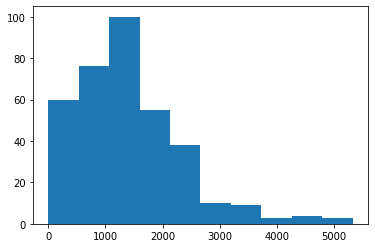

In [15]:
plt.hist(df_travel['Method of Travel to Work by Sex|Worked_at_home'])
plt.plot()

[]

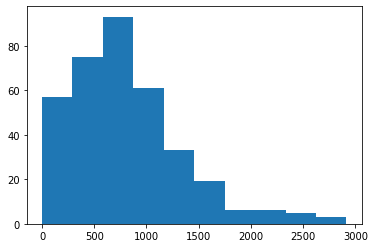

In [16]:
plt.hist(df_travel['Method of Travel to Work by Sex|Worked_at_home_Females'])
plt.plot()

[]

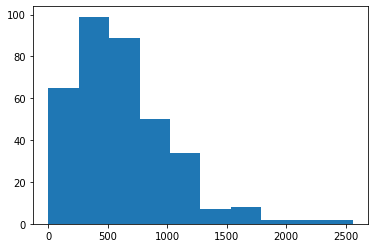

In [17]:
plt.hist(df_travel['Method of Travel to Work by Sex|Worked_at_home_Males'])
plt.plot()

In [20]:
# Look at the basic statistical comparisons between the two distributions
import scipy.stats  as stats
compar_stats =  stats.pearsonr(df_travel['Method of Travel to Work by Sex|Worked_at_home_Males'], 
                               df_travel['Method of Travel to Work by Sex|Worked_at_home_Females'])
print('Pearson Coeff: {} /n P-Value: {}'.format(compar_stats[0],compar_stats[1]))

Pearson Coeff: 0.9310479843447125 /n P-Value: 6.1557016817360395e-158


There seems to be more of a right skew to the data for Males working from home, so my basic hypothesis of testing whether there is a meaningful difference between models trained on total data vs gendered data may be worth exploring. That said, the p-value itself is incredibly low, low maybe I want to disaggregate a little further before really honing in on this. Then again, maybe that's p-hacking and I'm being evil in even contemplating that!

In [17]:
df_pop = cnss_func.load_census_csv(['G01'], statistical_area_code='SA3')
df_pop.set_index(df_pop.columns[0], inplace=True)
df_pop = df_pop.drop([x for x in df_pop.columns if x != 'Tot_P_P'], axis=1)
df_pop.head()

,Tot_P_P
SA3_CODE_2016,
10102,57331
10103,19366
10104,70638
10105,35559
10106,35942


In [18]:
df_travel = df_travel.merge(df_pop, left_index=True, right_index=True)
df_travel.head()

,Method of Travel to Work by Sex|Worked_at_home,Method of Travel to Work by Sex|Worked_at_home_Females,Method of Travel to Work by Sex|Worked_at_home_Males,Tot_P_P
10102,1134,674,459,57331
10103,777,385,388,19366
10104,1788,963,825,70638
10105,994,473,519,35559
10106,1424,695,724,35942


In [19]:
# Create new "Work From Home Participation Rate" vector to ensure consistency across regions
# Base this off population who worked from home divided by total population in the region
df_travel['WFH_Participaction'] = (df_travel['Method of Travel to Work by Sex|Worked_at_home']/
                                   df_travel['Tot_P_P'])
df_travel.head()

,Method of Travel to Work by Sex|Worked_at_home,Method of Travel to Work by Sex|Worked_at_home_Females,Method of Travel to Work by Sex|Worked_at_home_Males,Tot_P_P,WFH_Participaction
10102,1134,674,459,57331,0.019780
10103,777,385,388,19366,0.040122
10104,1788,963,825,70638,0.025312
10105,994,473,519,35559,0.027954
10106,1424,695,724,35942,0.039619


In [20]:
# load input vectors
load_tables = tables_to_load
load_features = ['Age','Income','Occupation',
                 'Family Composition','Internet status',
                 'Building occupation status','Number of Bedrooms',
                 'Place of Birth','Country of Birth of Parents','Year of Arrival']
input_vectors = cnss_func.load_tables_specify_cats(load_tables, load_features, statistical_area_code='SA3')
# Remove duplicate column values
input_vectors = input_vectors.T.drop_duplicates().T

# Bring in total population field and scale all the values by this item
input_vectors = input_vectors.merge(df_pop, left_index=True, right_index=True)

# convert input features to numeric
cols = input_vectors.columns
input_vectors[cols] = input_vectors[cols].apply(pd.to_numeric, errors='coerce')

In [21]:
# Drop rows with zero population
input_vectors = input_vectors.dropna(subset=['Tot_P_P'])
input_vectors = input_vectors[input_vectors['Tot_P_P'] > 0]

# Scale all factors by total region population
for cols in input_vectors.columns:
    if cols !='Tot_P_P':
        input_vectors[cols] = input_vectors[cols]/input_vectors['Tot_P_P']

input_vectors.head()

,Selected Person Characteristics by Sex|Age_groups_0_4_years,Selected Person Characteristics by Sex|Age_groups_15_19_years,Selected Person Characteristics by Sex|Age_groups_20_24_years,Selected Person Characteristics by Sex|Age_groups_25_34_years,Selected Person Characteristics by Sex|Age_groups_35_44_years,Selected Person Characteristics by Sex|Age_groups_45_54_years,Selected Person Characteristics by Sex|Age_groups_55_64_years,Selected Person Characteristics by Sex|Age_groups_5_14_years,Selected Person Characteristics by Sex|Age_groups_65_74_years,Selected Person Characteristics by Sex|Age_groups_75_84_years,...,Occupation by Age by Sex|85_years_and_over_Occupation_technicians_and_trades_workers,Occupation by Hours Worked by Sex|Clerical_and_administrative_workers,Occupation by Hours Worked by Sex|Community_and_personal_service_workers,Occupation by Hours Worked by Sex|Labourers,Occupation by Hours Worked by Sex|Machinery_operators_and_drivers,Occupation by Hours Worked by Sex|Managers,Occupation by Hours Worked by Sex|Professionals,Occupation by Hours Worked by Sex|Sales_workers,Occupation by Hours Worked by Sex|Technicians_and_trades_workers,Tot_P_P
index,,,,,,,,,,,,,,,,,,,,,
10102,0.064956,0.062619,0.057351,0.135982,0.140378,0.160105,0.125081,0.131029,0.077201,0.033350,...,0.000052,0.095463,0.053915,0.037711,0.024245,0.084771,0.104132,0.041147,0.070573,57331
10103,0.046628,0.058246,0.053806,0.111691,0.120211,0.150212,0.143086,0.122276,0.113240,0.057678,...,0.000000,0.055355,0.059847,0.059073,0.032015,0.091552,0.066250,0.046267,0.068161,19366
10104,0.041833,0.051007,0.034910,0.072213,0.092613,0.132195,0.183641,0.108398,0.165577,0.083935,...,0.000042,0.043192,0.047156,0.046519,0.020810,0.047949,0.059288,0.041465,0.058410,70638
10105,0.058354,0.059113,0.052982,0.112714,0.116004,0.138474,0.138165,0.121488,0.114879,0.062881,...,0.000084,0.051070,0.063191,0.051042,0.034759,0.062685,0.061560,0.039906,0.061841,35559
10106,0.061488,0.062239,0.046881,0.090952,0.122086,0.143453,0.136609,0.140254,0.115519,0.057259,...,0.000139,0.058650,0.045490,0.053169,0.025068,0.091954,0.074398,0.034973,0.060904,35942


In [23]:
# merge and drop na values from the response vector
df_travel = df_travel.merge(input_vectors, left_index=True, right_index=True)
df_travel = df_travel.dropna(subset=['WFH_Participaction'])

,Method of Travel to Work by Sex|Worked_at_home,Method of Travel to Work by Sex|Worked_at_home_Females,Method of Travel to Work by Sex|Worked_at_home_Males,Tot_P_P_x,WFH_Participaction,Selected Person Characteristics by Sex|Age_groups_0_4_years_x,Selected Person Characteristics by Sex|Age_groups_15_19_years_x,Selected Person Characteristics by Sex|Age_groups_20_24_years_x,Selected Person Characteristics by Sex|Age_groups_25_34_years_x,Selected Person Characteristics by Sex|Age_groups_35_44_years_x,...,Occupation by Age by Sex|85_years_and_over_Occupation_technicians_and_trades_workers_y,Occupation by Hours Worked by Sex|Clerical_and_administrative_workers_y,Occupation by Hours Worked by Sex|Community_and_personal_service_workers_y,Occupation by Hours Worked by Sex|Labourers_y,Occupation by Hours Worked by Sex|Machinery_operators_and_drivers_y,Occupation by Hours Worked by Sex|Managers_y,Occupation by Hours Worked by Sex|Professionals_y,Occupation by Hours Worked by Sex|Sales_workers_y,Occupation by Hours Worked by Sex|Technicians_and_trades_workers_y,Tot_P_P
10102,1134,674,459,57331,0.019780,0.064956,0.062619,0.057351,0.135982,0.140378,...,0.000052,0.095463,0.053915,0.037711,0.024245,0.084771,0.104132,0.041147,0.070573,57331
10103,777,385,388,19366,0.040122,0.046628,0.058246,0.053806,0.111691,0.120211,...,0.000000,0.055355,0.059847,0.059073,0.032015,0.091552,0.066250,0.046267,0.068161,19366
10104,1788,963,825,70638,0.025312,0.041833,0.051007,0.034910,0.072213,0.092613,...,0.000042,0.043192,0.047156,0.046519,0.020810,0.047949,0.059288,0.041465,0.058410,70638
10105,994,473,519,35559,0.027954,0.058354,0.059113,0.052982,0.112714,0.116004,...,0.000084,0.051070,0.063191,0.051042,0.034759,0.062685,0.061560,0.039906,0.061841,35559
10106,1424,695,724,35942,0.039619,0.061488,0.062239,0.046881,0.090952,0.122086,...,0.000139,0.058650,0.045490,0.053169,0.025068,0.091954,0.074398,0.034973,0.060904,35942


In [24]:
df_travel = df_travel.drop(['Method of Travel to Work by Sex|Worked_at_home',
                            'Method of Travel to Work by Sex|Worked_at_home_Females',
                            'Method of Travel to Work by Sex|Worked_at_home_Males',
                            'Tot_P_P_x','Tot_P_P'], axis=1)
df_travel.head()

,WFH_Participaction,Selected Person Characteristics by Sex|Age_groups_0_4_years_x,Selected Person Characteristics by Sex|Age_groups_15_19_years_x,Selected Person Characteristics by Sex|Age_groups_20_24_years_x,Selected Person Characteristics by Sex|Age_groups_25_34_years_x,Selected Person Characteristics by Sex|Age_groups_35_44_years_x,Selected Person Characteristics by Sex|Age_groups_45_54_years_x,Selected Person Characteristics by Sex|Age_groups_55_64_years_x,Selected Person Characteristics by Sex|Age_groups_5_14_years_x,Selected Person Characteristics by Sex|Age_groups_65_74_years_x,...,Occupation by Age by Sex|85_years_and_over_Occupation_sales_workers_y,Occupation by Age by Sex|85_years_and_over_Occupation_technicians_and_trades_workers_y,Occupation by Hours Worked by Sex|Clerical_and_administrative_workers_y,Occupation by Hours Worked by Sex|Community_and_personal_service_workers_y,Occupation by Hours Worked by Sex|Labourers_y,Occupation by Hours Worked by Sex|Machinery_operators_and_drivers_y,Occupation by Hours Worked by Sex|Managers_y,Occupation by Hours Worked by Sex|Professionals_y,Occupation by Hours Worked by Sex|Sales_workers_y,Occupation by Hours Worked by Sex|Technicians_and_trades_workers_y
10102,0.019780,0.064956,0.062619,0.057351,0.135982,0.140378,0.160105,0.125081,0.131029,0.077201,...,0.0,0.000052,0.095463,0.053915,0.037711,0.024245,0.084771,0.104132,0.041147,0.070573
10103,0.040122,0.046628,0.058246,0.053806,0.111691,0.120211,0.150212,0.143086,0.122276,0.113240,...,0.0,0.000000,0.055355,0.059847,0.059073,0.032015,0.091552,0.066250,0.046267,0.068161
10104,0.025312,0.041833,0.051007,0.034910,0.072213,0.092613,0.132195,0.183641,0.108398,0.165577,...,0.0,0.000042,0.043192,0.047156,0.046519,0.020810,0.047949,0.059288,0.041465,0.058410
10105,0.027954,0.058354,0.059113,0.052982,0.112714,0.116004,0.138474,0.138165,0.121488,0.114879,...,0.0,0.000084,0.051070,0.063191,0.051042,0.034759,0.062685,0.061560,0.039906,0.061841
10106,0.039619,0.061488,0.062239,0.046881,0.090952,0.122086,0.143453,0.136609,0.140254,0.115519,...,0.0,0.000139,0.058650,0.045490,0.053169,0.025068,0.091954,0.074398,0.034973,0.060904


In [27]:
# Remove duplicate column values
df_travel = df_travel.T.drop_duplicates().T

In [28]:
# Investigate correlations to check out items which stand out as potential drivers
response_vector = 'WFH_Participaction'
cnss_func.sort_series_abs(df_travel.corr().loc[:,response_vector])[1:50]

Occupation by Age by Sex|65_74_years_Occupation_managers_x                                                                                                                            0.800478
Occupation by Age by Sex|55_64_years_Occupation_managers_x                                                                                                                            0.772749
Industry of Employment by Age by Sex|Age_75_84_years_x_x                                                                                                                              0.711729
Industry of Employment by Occupation|Occupation_managers_x                                                                                                                            0.686600
Occupation by Hours Worked by Sex|Managers_x                                                                                                                                          0.684285
Industry of Employment by Age by Sex|Age_75_8

### Basic correlation reflections
Pretty interesting that there is a strong trend for significantly senior managers (those over the typical retirement age) to have a strong correlation with working from home participation. Unsurprisingly there are negative correlations with machinery operators and low income earners. It also kind of surprises me that there is a negative correlation with parents of young children. For some reason I expected they would be more likely to push for working from home arrangements to allow them flexibility in home management during an intense period of child rearing.

### Train model

In [29]:
# Create X & y
X = df_travel.drop(response_vector, axis=1)
y = df_travel[response_vector]

In [30]:
# Split the 'features' and 'response' vectors into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [22]:
# build a pipelines to fill NaNs with medians
#note to self, it may be interesting to explore the functionality of IUterativeImputer instead of SimpleImputer
def build_model():
    ''' Impute for missing values and build a model to complete a quick
    Grid search over RandomForestRegressor key parameters.
    '''
    pipeline_model = Pipeline([
        ('impute', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('clf', RandomForestRegressor(n_estimators=100, random_state=42, max_depth=100))
    ])
    # specify parameters for grid search
    parameters = {'clf__n_estimators':[10,20,40], # this used to go to 80 but was a huge timesuck and not improving performance
              'clf__max_depth':[16,32,64], # this used to go to 128 but had no impact on performance
              #'clf__min_samples_leaf':[1,2,4] This wasn't really having an impact on performance
             }

    # create grid search object
    scorer = make_scorer(r2_score)
    cv = GridSearchCV(pipeline_model, param_grid=parameters, scoring=scorer, verbose = 3)

    return cv

In [33]:
grid_obj = build_model()

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_rf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
y_pred = best_rf.predict(X_test)

best_rf

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10, score=0.833, total=   0.9s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10, score=0.766, total=   1.0s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10, score=0.803, total=   1.0s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20, score=0.827, total=   1.7s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20, score=0.762, total=   1.8s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20, score=0.818, total=   1.7s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=40 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=40, score=0.846, total=   3.3s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=40 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=40, score=0.781, total=   3.4s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, cl

[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=20, score=0.841, total=   1.5s
[CV] clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=20 
[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=20, score=0.769, total=   1.5s
[CV] clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=20 
[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=20, score=0.825, total=   1.6s
[CV] clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40 
[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40, score=0.852, total=   2.9s
[CV] clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40 
[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40, score=0.779, total=   3.0s
[CV] clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40 
[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40, score=0.843, total=   3.1s
[CV] clf__max_depth=32, clf__min_samples_leaf=2, cl

[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=20, score=0.762, total=   1.3s
[CV] clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=20 
[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=20, score=0.833, total=   1.4s
[CV] clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40 
[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40, score=0.850, total=   2.5s
[CV] clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40 
[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40, score=0.762, total=   2.6s
[CV] clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40 
[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40, score=0.832, total=   2.7s
[CV] clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=80 
[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=80, score=0.829, total=   4.9s
[CV] clf__max_depth=64, clf__min_samples_leaf=4, cl

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  6.9min finished


Pipeline(memory=None,
         steps=[('impute',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('clf',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=16, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=2, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=40, n_jobs=None,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)

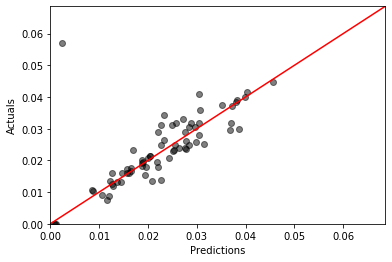

In [34]:
lineStart = min(y_pred.min(), y_test.min())  
lineEnd = max(y_pred.max()*1.2, y_test.max()*1.2)

plt.figure()
plt.scatter(y_pred, y_test, color = 'k', alpha=0.5)
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd)
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.show()

In [35]:
y_test[y_test == y_test.max()]

79797    0.057143
Name: WFH_Participaction, dtype: float64

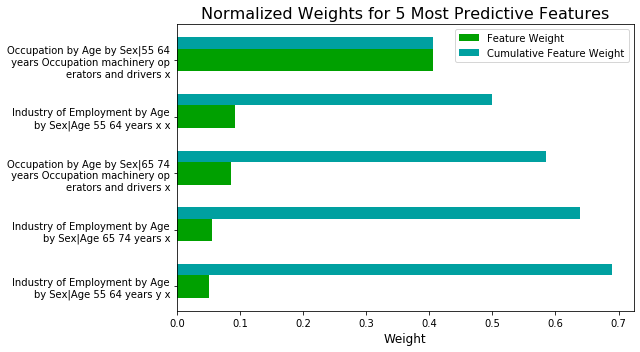

In [37]:
cnss_func.feature_plot_h(grid_fit.best_estimator_.steps[1][1], X_train, 5)

In [38]:
r2_score(y_pred, y_test)

0.4067779948967266

In [39]:
# This r2_score seems really low, is it being driven by the outlier?
y_pred_2 = best_rf.predict(X_test.drop(79797))

In [40]:
r2_score(y_pred_2, y_test.drop(79797))

0.8307053072154962

R2 Score:0.8458693762707619


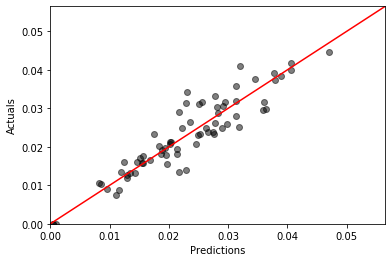

In [71]:
model_analyse_pred(X_test_sa3.drop(79797), y_test_sa3.drop(79797), model_sa3)

## Space for initial thoughts
Excluding the extreme outlier, there is a great level of accuracy in predicting with this model, with an r2 score of 0.83. Let's see what happens at an SA2 level.

In [44]:
# Load table 59 (the one with commute mechanism) and have a quick look at the distribution of WFH by sex
df_travel_sa2 = cnss_func.load_table_refined('G59', ['Number of Commuting Methods'], statistical_area_code='SA2')
cols_to_delete = [x for x in df_travel_sa2.columns if 'Worked_at_home' not in x]
df_travel_sa2.drop(cols_to_delete,axis=1, inplace=True)
df_travel_sa2.head()

Test_name,Method of Travel to Work by Sex|Worked_at_home
101021007,223
101021008,75
101021009,101
101021010,68
101021011,508


In [23]:
def model_WFH(stat_a_level):
    # Load table 59 (the one with commute mechanism)
    df_travel = cnss_func.load_table_refined('G59', ['Number of Commuting Methods'], statistical_area_code=stat_a_level)
    cols_to_delete = [x for x in df_travel.columns if 'Worked_at_home' not in x]
    df_travel.drop(cols_to_delete,axis=1, inplace=True)

    df_pop = cnss_func.load_census_csv(['G01'], statistical_area_code=stat_a_level)
    df_pop.set_index(df_pop.columns[0], inplace=True)
    df_pop = df_pop.drop([x for x in df_pop.columns if x != 'Tot_P_P'], axis=1)
    df_travel = df_travel.merge(df_pop, left_index=True, right_index=True)
    
    # Create new "Work From Home Participation Rate" vector to ensure consistency across regions
    # Base this off population who worked from home divided by total population in the region
    df_travel['WFH_Participaction'] = (df_travel['Method of Travel to Work by Sex|Worked_at_home']/
                                       df_travel['Tot_P_P'])
    
    df_travel = df_travel.drop(['Method of Travel to Work by Sex|Worked_at_home'], axis=1)
    
    # load input vectors
    load_tables = tables_to_load
    load_features = ['Age','Income','Occupation',
                     'Family Composition','Internet status',
                     'Building occupation status','Number of Bedrooms',
                     'Place of Birth','Country of Birth of Parents','Year of Arrival']
    
    input_vectors = cnss_func.load_tables_specify_cats(load_tables, load_features, statistical_area_code=stat_a_level)
    
    # Remove duplicate column values
    input_vectors = input_vectors.T.drop_duplicates().T

    # Bring in total population field and scale all the values by this item
    input_vectors = input_vectors.merge(df_pop, left_index=True, right_index=True)

    # convert input features to numeric
    cols = input_vectors.columns
    input_vectors[cols] = input_vectors[cols].apply(pd.to_numeric, errors='coerce')

    # Drop rows with zero population
    input_vectors = input_vectors.dropna(subset=['Tot_P_P'])
    input_vectors = input_vectors[input_vectors['Tot_P_P'] > 0]

    # Scale all factors by total region population
    for cols in input_vectors.columns:
        if cols !='Tot_P_P':
            input_vectors[cols] = input_vectors[cols]/input_vectors['Tot_P_P']

    # merge and drop na values from the response vector
    df_travel = df_travel.merge(input_vectors, left_index=True, right_index=True)
    df_travel = df_travel.dropna(subset=['WFH_Participaction'])

    df_travel = df_travel.drop([x for x in df_travel.columns if 'Tot_P_P' in x], axis=1)

    # Remove duplicate column values
    df_travel = df_travel.T.drop_duplicates().T

    # Investigate correlations to check out items which stand out as potential drivers
    response_vector = 'WFH_Participaction'

    # Create X & y
    X = df_travel.drop(response_vector, axis=1)
    y = df_travel[response_vector]

    # Split the 'features' and 'response' vectors into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    # build a model using all the above inputs
    grid_obj = build_model()

    # TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator
    return grid_fit.best_estimator_, X_train, X_test, y_train, y_test, X

In [47]:
# Make predictions using the unoptimized and model
prediction_model, X_train_sa2, X_test_sa2, y_train_sa2, y_test_sa2, X = model_WFH('SA2')

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10, score=0.080, total=   8.7s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s


[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10, score=0.409, total=   9.6s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.3s remaining:    0.0s


[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10, score=-0.619, total=   9.9s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20, score=0.049, total=  16.7s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20, score=0.432, total=  18.7s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20, score=0.039, total=  19.3s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=40 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=40, score=0.049, total=  32.8s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=40 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=40, score=0.455, total=  36.0s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, c

[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=20, score=0.070, total=  15.8s
[CV] clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=20 
[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=20, score=0.718, total=  17.2s
[CV] clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=20 
[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=20, score=0.228, total=  17.8s
[CV] clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40 
[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40, score=0.069, total=  30.6s
[CV] clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40 
[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40, score=0.660, total=  34.0s
[CV] clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40 
[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40, score=0.008, total=  35.5s
[CV] clf__max_depth=32, clf__min_samples_leaf=2, cl

[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=20, score=0.739, total=  16.9s
[CV] clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=20 
[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=20, score=0.323, total=  17.5s
[CV] clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40 
[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40, score=0.075, total=  30.4s
[CV] clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40 
[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40, score=0.736, total=  33.3s
[CV] clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40 
[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40, score=0.353, total=  34.5s
[CV] clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=80 
[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=80, score=0.078, total= 1.0min
[CV] clf__max_depth=64, clf__min_samples_leaf=4, cl

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 78.4min finished
C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ValueError: X has 2852 features per sample, expected 2841

In [48]:
y_pred_sa2 = prediction_model.predict(X_test_sa2)

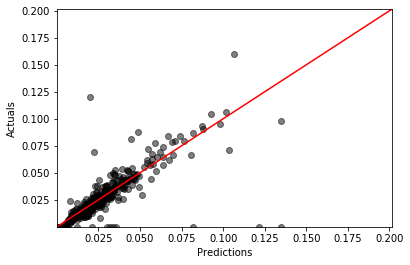

In [49]:
lineStart = min(y_pred_sa2.min(), y_pred_sa2.min())  
lineEnd = max(y_pred_sa2.max()*1.2, y_pred_sa2.max()*1.2)

plt.figure()
plt.scatter(y_pred_sa2, y_test_sa2, color = 'k', alpha=0.5)
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd)
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.show()

In [50]:
r2_score(y_pred_sa2, y_test_sa2)

0.22809837850766657

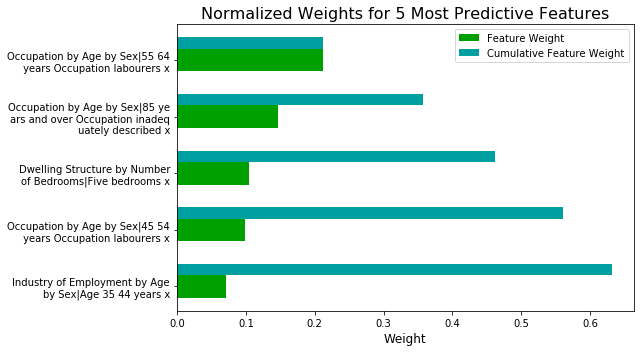

In [51]:
cnss_func.feature_plot_h(prediction_model.steps[1][1], X_train, 5)

In [52]:
import pickle
pickle.dump(prediction_model, open('classifier_sa2.pkl', 'wb'))
pickle.dump(best_rf, open('classifier_sa3.pkl', 'wb'))

### Observations on SA2 level data
So at a quick look, the R2 score has dropped dramatically and thus so has the utility of the model. The model seems pretty bad at predicting a few of the cases where the actual recorded work from home data has a rate of 0. I may try a case where I exclude any zero values from the dataset itself and see what impact that has. My other main impression is that the drop off in accuracy seems intuitive to me, because making more granular predictions is simply more difficult, even with more granular data (e.g. what is the weather going to be at 10-11am vs what is the weather going to be for the day).

Additionally, I am keen to get a hierarchy of Statistical Areas, to see if predictions at the SA2 level which are then aggregated at the SA3 level end up better or worse than models trained at the SA3 level in the first instance. As noted [here](https://www.abs.gov.au/ausstats/abs@.nsf/Lookup/by%20Subject/1270.0.55.001~July%202016~Main%20Features~Statistical%20Area%20Level%202%20(SA2)~10014), Statistical area codes are hierarchical, so it should be fairly straightforward to make predictions at the SA2 level, then aggregate by the first 5 characters in the index column to get to a prediction at the SA3 level.

In [ ]:
model_sa3, X_train_sa3, X_test_sa3, y_train_sa3, y_test_sa3, X_sa3 = model_WFH('SA3')
model_sa2, X_train_sa2, X_test_sa2, y_train_sa2, y_test_sa2, X_sa2 = model_WFH('SA2')
model_sa1, X_train_sa1, X_test_sa1, y_train_sa1, y_test_sa1, X_sa1 = model_WFH('SA1')

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10, score=0.824, total=   1.8s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10, score=0.724, total=   1.5s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10, score=0.791, total=   1.8s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20, score=0.829, total=   3.3s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20, score=0.746, total=   2.8s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20, score=0.817, total=   2.2s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=40 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=40, score=0.849, total=   4.1s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=40 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=40, score=0.764, total=   4.1s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, cl

[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=20, score=0.839, total=   1.6s
[CV] clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=20 
[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=20, score=0.752, total=   1.6s
[CV] clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=20 
[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=20, score=0.836, total=   1.8s
[CV] clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40 
[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40, score=0.851, total=   3.2s
[CV] clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40 
[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40, score=0.764, total=   3.2s
[CV] clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40 
[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40, score=0.841, total=   3.1s
[CV] clf__max_depth=32, clf__min_samples_leaf=2, cl

[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=20, score=0.759, total=   1.3s
[CV] clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=20 
[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=20, score=0.833, total=   1.3s
[CV] clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40 
[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40, score=0.852, total=   2.5s
[CV] clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40 
[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40, score=0.770, total=   2.6s
[CV] clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40 
[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40, score=0.829, total=   2.7s
[CV] clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=80 
[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=80, score=0.829, total=   4.9s
[CV] clf__max_depth=64, clf__min_samples_leaf=4, cl

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  7.5min finished
C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10, score=0.080, total=   8.8s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s


[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10, score=0.409, total=  10.1s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.7s remaining:    0.0s


[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10, score=-0.619, total=  10.2s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20, score=0.049, total=  17.0s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20, score=0.432, total=  18.7s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20, score=0.039, total=  21.0s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=40 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=40, score=0.049, total=  35.4s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=40 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=40, score=0.455, total=  36.7s
[CV] clf__max_depth=16, clf__min_samples_leaf=1, c

[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=20, score=0.070, total=  17.9s
[CV] clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=20 
[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=20, score=0.718, total=  19.7s
[CV] clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=20 
[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=20, score=0.228, total=  19.7s
[CV] clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40 
[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40, score=0.069, total=  33.0s
[CV] clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40 
[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40, score=0.660, total=  38.7s
[CV] clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40 
[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40, score=0.008, total=  41.8s
[CV] clf__max_depth=32, clf__min_samples_leaf=2, cl

[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=20, score=0.739, total=  16.0s
[CV] clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=20 
[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=20, score=0.323, total=  17.6s
[CV] clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40 
[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40, score=0.075, total=  29.7s
[CV] clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40 
[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40, score=0.736, total=  31.6s
[CV] clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40 
[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40, score=0.353, total=  32.9s
[CV] clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=80 
[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=80, score=0.078, total=  59.9s
[CV] clf__max_depth=64, clf__min_samples_leaf=4, cl

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 78.9min finished
C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10, score=0.700, total= 3.9min
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.9min remaining:    0.0s


[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10, score=0.813, total= 3.8min
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.7min remaining:    0.0s


[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=10, score=0.808, total= 3.6min
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20, score=0.736, total= 6.2min
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20, score=0.797, total= 5.9min
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=20, score=0.796, total= 5.7min
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=40 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=40, score=0.724, total=11.0min
[CV] clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=40 
[CV]  clf__max_depth=16, clf__min_samples_leaf=1, clf__n_estimators=40, score=0.792, total=11.2min
[CV] clf__max_depth=16, clf__min_samples_leaf=1, cl

[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=20, score=0.753, total= 6.1min
[CV] clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=20 
[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=20, score=0.843, total= 6.2min
[CV] clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=20 
[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=20, score=0.820, total= 6.2min
[CV] clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40 
[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40, score=0.785, total=12.1min
[CV] clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40 
[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40, score=0.854, total=12.4min
[CV] clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40 
[CV]  clf__max_depth=32, clf__min_samples_leaf=2, clf__n_estimators=40, score=0.820, total=12.2min
[CV] clf__max_depth=32, clf__min_samples_leaf=2, cl

[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=20, score=0.857, total= 6.5min
[CV] clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=20 
[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=20, score=0.797, total= 6.6min
[CV] clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40 
[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40, score=0.811, total=12.4min
[CV] clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40 
[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40, score=0.854, total=12.6min
[CV] clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40 
[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=40, score=0.804, total=12.3min
[CV] clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=80 
[CV]  clf__max_depth=64, clf__min_samples_leaf=4, clf__n_estimators=80, score=0.807, total=22.7min
[CV] clf__max_depth=64, clf__min_samples_leaf=4, cl

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 1730.9min finished


### Retraining after further analysis

Retraining data by dropping areas with zero geographical area (this was the item driving the big outlier in the first training set above).

In [6]:
# Save all the components as reference files so I can quickly refer to these again in the future 
# rather than re-training from scratch
model_sa3, X_train_sa3, X_test_sa3, y_train_sa3, y_test_sa3, X_sa3 = model_WFH('SA3')

X_train_sa3.to_csv('{}\X_train_sa3.csv'.format(nb_path))
X_test_sa3.to_csv('{}\X_test_sa3.csv'.format(nb_path))
y_train_sa3.to_csv('{}\y_train_sa3.csv'.format(nb_path))
y_test_sa3.to_csv('{}\y_test_sa3.csv'.format(nb_path))
X_sa3.to_csv('{}\X_sa3.csv'.format(nb_path))
pickle.dump(model_sa3, open('model_sa3.pkl', 'wb'))

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.794, total=   1.7s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.738, total=   1.6s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.719, total=   1.7s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.807, total=   3.2s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.737, total=   3.2s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.750, total=   3.3s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.794, total=   1.6s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.738, total=   1.6s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.719, total=   1.7s
[CV] clf__max_depth=32, clf__n_estimators=40 ...........

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   43.8s finished
C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  import sys
C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


R2 Score:0.5739985666426111


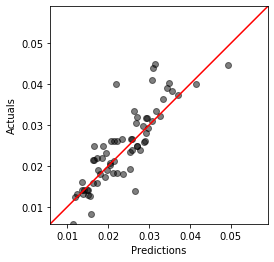

In [9]:
model_analyse_pred(X_test_sa3, y_test_sa3, model_sa3)

Strange that the performance actually decreased, but okay.

In [10]:
model_sa2, X_train_sa2, X_test_sa2, y_train_sa2, y_test_sa2, X_sa2 = model_WFH('SA2')

X_train_sa2.to_csv('{}\Saved data\X_train_sa2.csv'.format(nb_path))
X_test_sa2.to_csv('{}\Saved data\X_test_sa2.csv'.format(nb_path))
y_train_sa2.to_csv('{}\Saved data\y_train_sa2.csv'.format(nb_path))
y_test_sa2.to_csv('{}\Saved data\y_test_sa2.csv'.format(nb_path))
X_sa2.to_csv('{}\Saved data\X_sa2.csv'.format(nb_path))

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.336, total=  18.4s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.3s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.506, total=  18.1s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   36.4s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.254, total=  19.1s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.335, total=  36.0s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.533, total=  35.9s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.117, total=  36.3s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.338, total=  17.9s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.506, total=  18.6s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.232, total=  18.7s
[CV] clf__max_depth=32, clf__n_estimators=40 ...........

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  8.1min finished
C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """
C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [11]:
pickle.dump(model_sa2, open('{}\Saved data\model_sa2.pkl'.format(nb_path), 'wb'))

In [12]:
y_test_sa2.sort_values(ascending=False).head()

801101137    1.000000
801101134    0.428571
205051099    0.160000
315011397    0.107241
215011393    0.106768
Name: WFH_Participaction, dtype: float64

R2 Score:-10.959503327438291


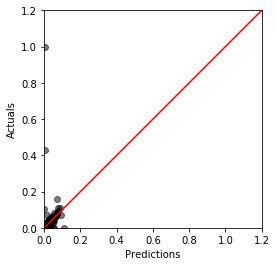

In [13]:
model_analyse_pred(X_test_sa2, y_test_sa2, model_sa2)

R2 Score:0.4683597005793322


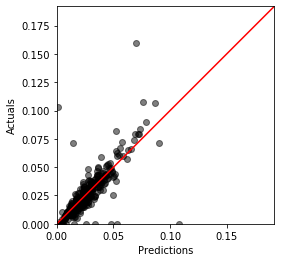

In [14]:
model_analyse_pred(X_test_sa2.drop([801101137,801101134]), y_test_sa2.drop([801101137,801101134]), model_sa2)

### Notes on SA2 data
There are clearly some large outliers in this dataset that needs understanding. a WFH ratio of "1" just does not seem possible at all.

Let's look at SA1 data, then come back to SA2.

In [15]:
model_sa1, X_train_sa1, X_test_sa1, y_train_sa1, y_test_sa1, X_sa1 = model_WFH('SA1')

X_train_sa1.to_csv('{}\Saved data\X_train_sa1.csv'.format(nb_path))
X_test_sa1.to_csv('{}\Saved data\X_test_sa1.csv'.format(nb_path))
y_train_sa1.to_csv('{}\Saved data\y_train_sa1.csv'.format(nb_path))
y_test_sa1.to_csv('{}\Saved data\y_test_sa1.csv'.format(nb_path))
X_sa1.to_csv('{}\Saved data\X_sa1.csv'.format(nb_path))

pickle.dump(model_sa1, open('{}\Saved data\model_sa1.pkl'.format(nb_path), 'wb'))

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.351, total= 6.8min
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.8min remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.456, total= 7.0min
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 13.8min remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.457, total= 7.4min
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.347, total=13.3min
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.468, total=12.8min
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.475, total=14.7min
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.356, total=14.2min
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.447, total=14.0min
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.451, total=12.7min
[CV] clf__max_depth=32, clf__n_estimators=40 ...........

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 251.9min finished
C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """
C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [16]:
model_sa1

Pipeline(memory=None,
         steps=[('impute',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('clf',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=32, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=40, n_jobs=None,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)

R2 Score:0.37641941865306716


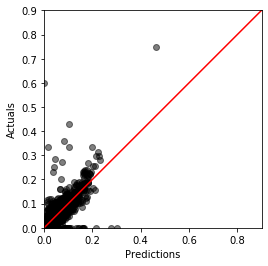

In [17]:
model_analyse_pred(X_test_sa1, y_test_sa1, model_sa1)

In [19]:
X_train_sa1 = pd.read_csv('{}\Saved data\X_train_sa1.csv'.format(nb_path))
X_train_sa1 = X_train_sa1.set_index(X_train_sa1.columns[0])

In [16]:
with open('{}\Saved data\model_sa1.pkl'.format(nb_path), 'rb') as f:
    model_sa1 = pickle.load(f)

NameError: name 'X_train' is not defined

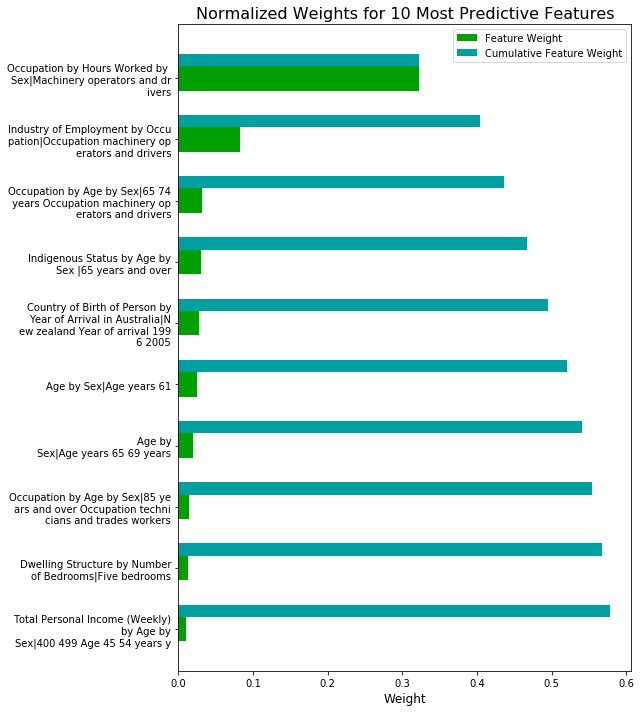

In [18]:
cnss_func.feature_plot_h(model_sa1.steps[1][1], X_train_sa1, 10)

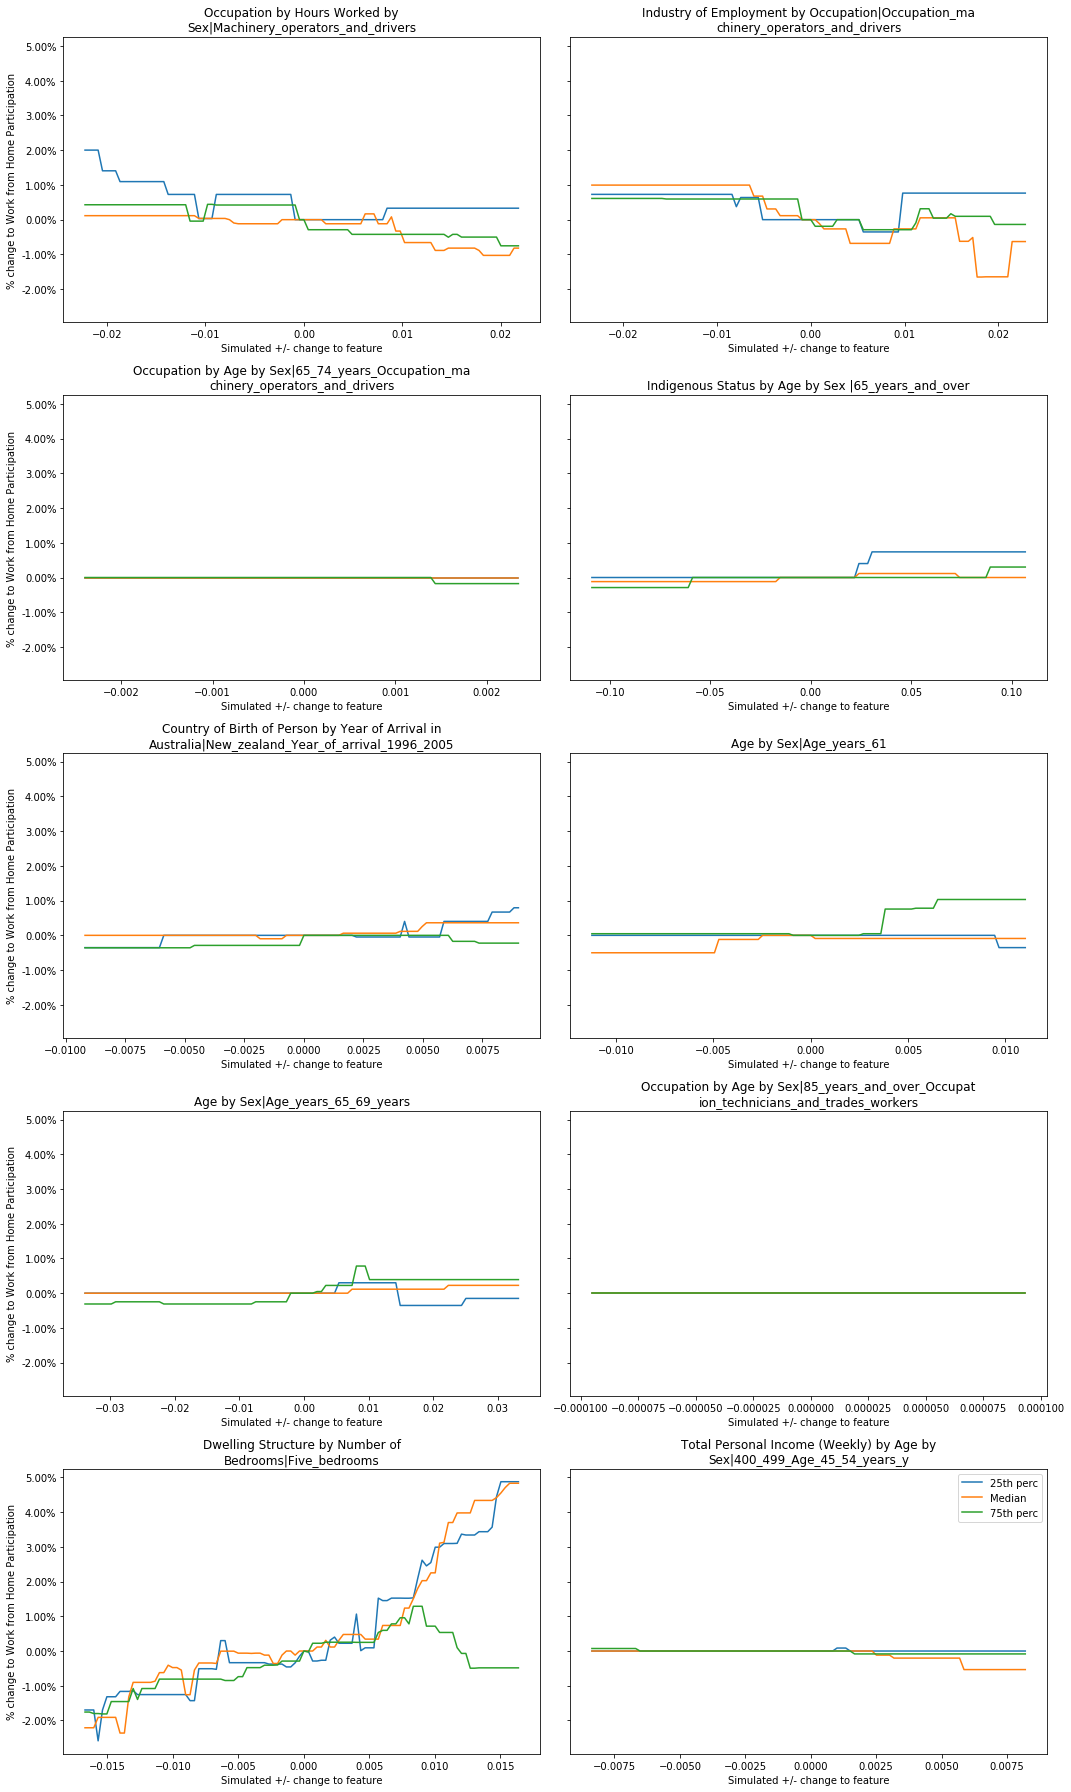

In [46]:
cnss_func.feature_impact_plot(model_sa1.steps[1][1], X_train_sa1, 10, 'Work from Home Participation', model_sa1)

In [23]:
print('SA3 level Work from home participation variance: {:.5f}'.format(df_response_sa3.iloc[:,0].var()))
print('SA2 level Work from home participation variance: {:.5f}'.format(df_response_sa2.iloc[:,0].var()))

SA3 level Work from home participation variance: 0.00012
SA2 level Work from home participation variance: 0.00105


### Reflections on SA1 Data
After working through a large amount of bugs in my initial workings, it appears the outcome is consistent with my initial hypothesis, but in a different (albeit still intuitive) way. Model performance does indeed deteriorate as detail gets more granular, but it appears this is largely attributable to a higher level of variance in the underlying data making it more difficult to predict. Whereas at an SA3 level it was incredibly unlikely to get a participation rate greater than 5%, at an SA1 or even occaisionally SA2 level there are instances of up to 100% participation in working from home! (My assumption based on a brief look at the actual locations is that this represents a few farmers).

## Comparisons
Below I will investigate and compare the factor importances between the models, the impacts of reducing the number of factors (given roughly 2000 variables, a 90% reduction may be interesting), as well as changing some of the category types we are bringing in in the first instance and seeing the impact on model performance (e.g. removing "Age" and its proxies, and bringing in "sex"). For starters regarding reducing characteristics, there seems to be a lot of overlap in some of the fields, which is just creating unnecessary noise in the feature importances (e.g. including both summary 'Age' as well as 'Occupation by age'), so I will first strip this list down, and then strip down the list by feature importances.

Given the length of time to train data at the SA1 level, for the time being I will stick to SA2 and SA3, since I have already proved my first hypothesis of shrinking prediction quality.

In [50]:
# Show tables which have the above fields of information available
df_meta = pd.read_csv('{}\Data\Metadata\Metadata_2016_refined.csv'.format(nb_path))
df_m_refined = df_meta[(df_meta['Age'] > 0) |
                      (df_meta['Income'] > 0) |
                      (df_meta['Occupation'] > 0) |
                      (df_meta['Family Composition'] > 0) |
                      (df_meta['Internet status'] > 0) |
                      (df_meta['Building occupation status'] > 0) |
                      (df_meta['Number of Bedrooms'] > 0) |
                      (df_meta['Place of Birth'] > 0) |
                      (df_meta['Country of Birth of Parents'] > 0) |
                      (df_meta['Year of Arrival'] > 0)]
for row in df_m_refined[['DataPack file','Table name']].drop_duplicates().iterrows():
    print(row)

(3, DataPack file                                       G01
Table name       Selected Person Characteristics by Sex
Name: 3, dtype: object)
(116, DataPack file                                                G03
Table name       Place of Usual Residence on Census Night by Age
Name: 116, dtype: object)
(256, DataPack file          G04A
Table name       Age by Sex
Name: 256, dtype: object)
(456, DataPack file          G04B
Table name       Age by Sex
Name: 456, dtype: object)
(562, DataPack file                                        G05
Table name       Registered Marital Status by Age by Sex
Name: 562, dtype: object)
(742, DataPack file                                    G06
Table name       Social Marital Status by Age by Sex
Name: 742, dtype: object)
(862, DataPack file                                 G07
Table name       Indigenous Status by Age by Sex 
Name: 862, dtype: object)
(1240, DataPack file                                        G09A
Table name       Country of Birth of Pers

In [115]:
# Hand pick the tables to load
tables_to_load = ['G57','G55','G37','G33','G34','G09']
load_features = ['Age','Income','Occupation',
                 'Family Composition','Internet status',
                 'Building occupation status','Number of Bedrooms',
                 'Place of Birth','Country of Birth of Parents','Year of Arrival']

In [116]:
# Save all the components as reference files so I can quickly refer to these again in the future 
# rather than re-training from scratch
model_sa3_ref, X_train_sa3_ref, X_test_sa3_ref, y_train_sa3_ref, y_test_sa3_ref, X_sa3_ref = model_WFH('SA3')

X_train_sa3_ref.to_csv('{}\X_train_sa3_ref.csv'.format(nb_path))
X_test_sa3_ref.to_csv('{}\X_test_sa3_ref.csv'.format(nb_path))
y_train_sa3_ref.to_csv('{}\y_train_sa3_ref.csv'.format(nb_path))
y_test_sa3_ref.to_csv('{}\y_test_sa3_ref.csv'.format(nb_path))
X_sa3_ref.to_csv('{}\X_sa3_ref.csv'.format(nb_path))
pickle.dump(model_sa3_ref, open('model_sa3_ref.pkl', 'wb'))

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.780, total=   0.4s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.733, total=   0.4s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.714, total=   0.4s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.816, total=   0.7s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.738, total=   0.6s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.763, total=   0.7s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.780, total=   0.3s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.733, total=   0.3s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.714, total=   0.3s
[CV] clf__max_depth=32, clf__n_estimators=40 ...........

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    9.1s finished
C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  import sys
C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


R2 Score:0.5943354955184157


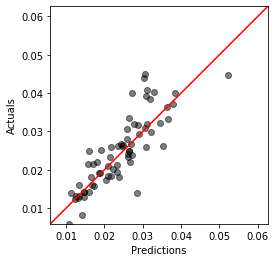

In [117]:
model_analyse_pred(X_test_sa3_ref, y_test_sa3_ref, model_sa3_ref)

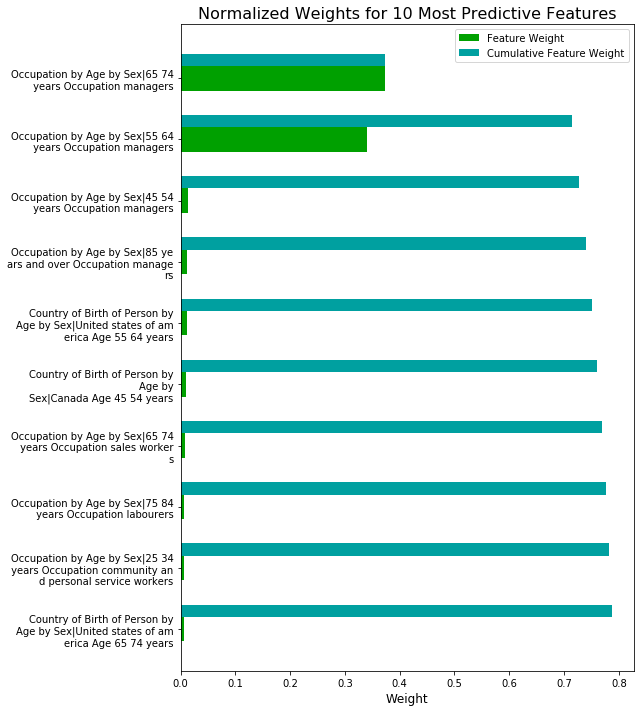

In [118]:
cnss_func.feature_plot_h(model_sa3_ref.steps[1][1], X_train_sa3_ref, 10)

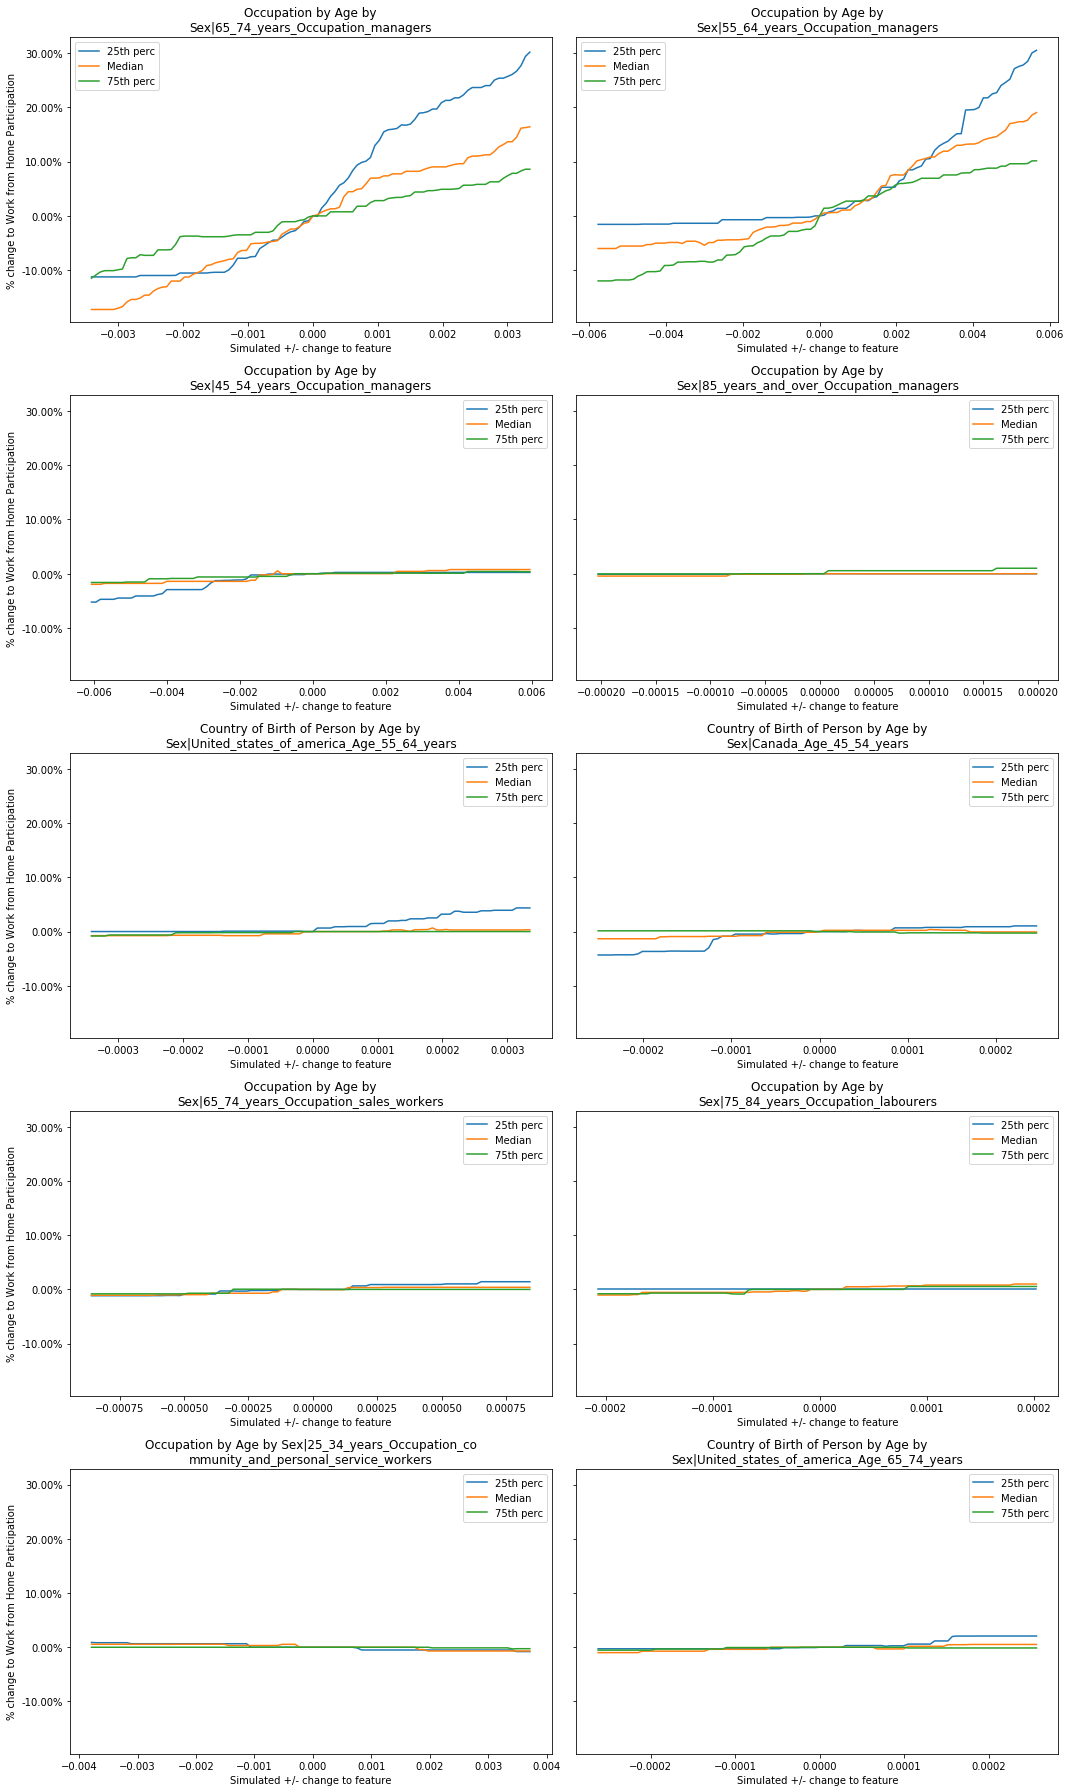

In [119]:
cnss_func.feature_impact_plot(model_sa3_ref.steps[1][1], X_train_sa3_ref, 10, 'Work from Home Participation', model_sa3_ref)

In [121]:
# Reduce feature count to top 100
top_100_feats = cnss_func.top_n_features(model_sa3_ref.steps[1][1], X_train_sa3_ref, 100)

In [124]:
# Create X & y
X_sa3_100 = X_sa3_ref[top_100_feats]
y_sa3 = df_response.copy().iloc[:,0]

# Split the 'features' and 'response' vectors into training and testing sets
# Change random state to avoid weird fitting patterns
X_train_sa3_100, X_test_sa3_100, y_train_sa3_100, y_test_sa3_100 = train_test_split(X_sa3_100, 
                                                                                    y_sa3, 
                                                                                    test_size = 0.2, 
                                                                                    random_state = 52)

# build a model using all the above inputs
grid_obj_sa3_100 = build_model()

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit_sa3_100 = grid_obj_sa3_100.fit(X_train_sa3_100, y_train_sa3_100)
model_sa3_100 = grid_fit_sa3_100.best_estimator_

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.696, total=   0.1s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.789, total=   0.1s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.831, total=   0.1s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.715, total=   0.2s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.794, total=   0.2s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.821, total=   0.2s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.1s finished
C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


R2 Score:0.6949648068247536


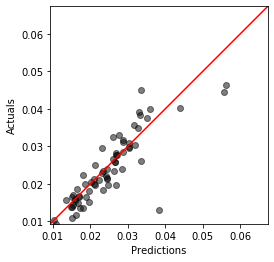

In [149]:
model_analyse_pred(X_test_sa3_100, y_test_sa3_100, model_sa3_100)

Hey we basically hit the 0.7 R2 score benchmark I set myself at the start!

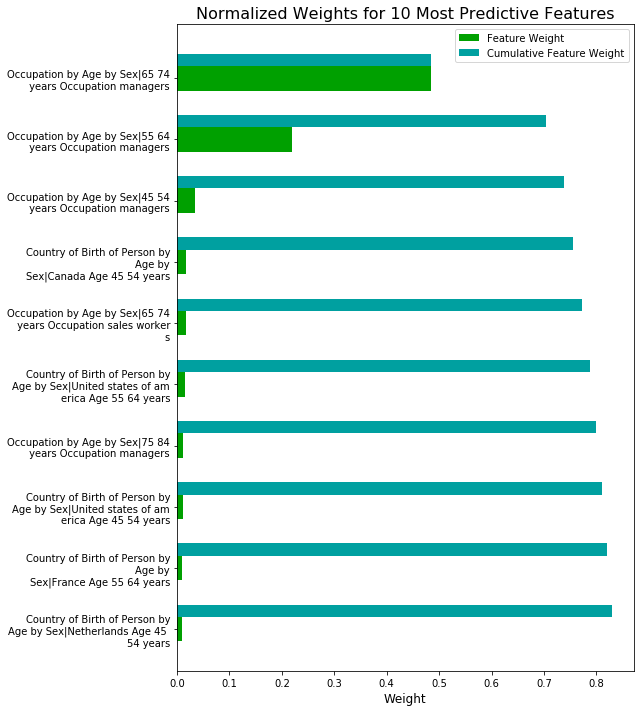

In [127]:
cnss_func.feature_plot_h(model_sa3_100.steps[1][1], X_train_sa3_100, 10)

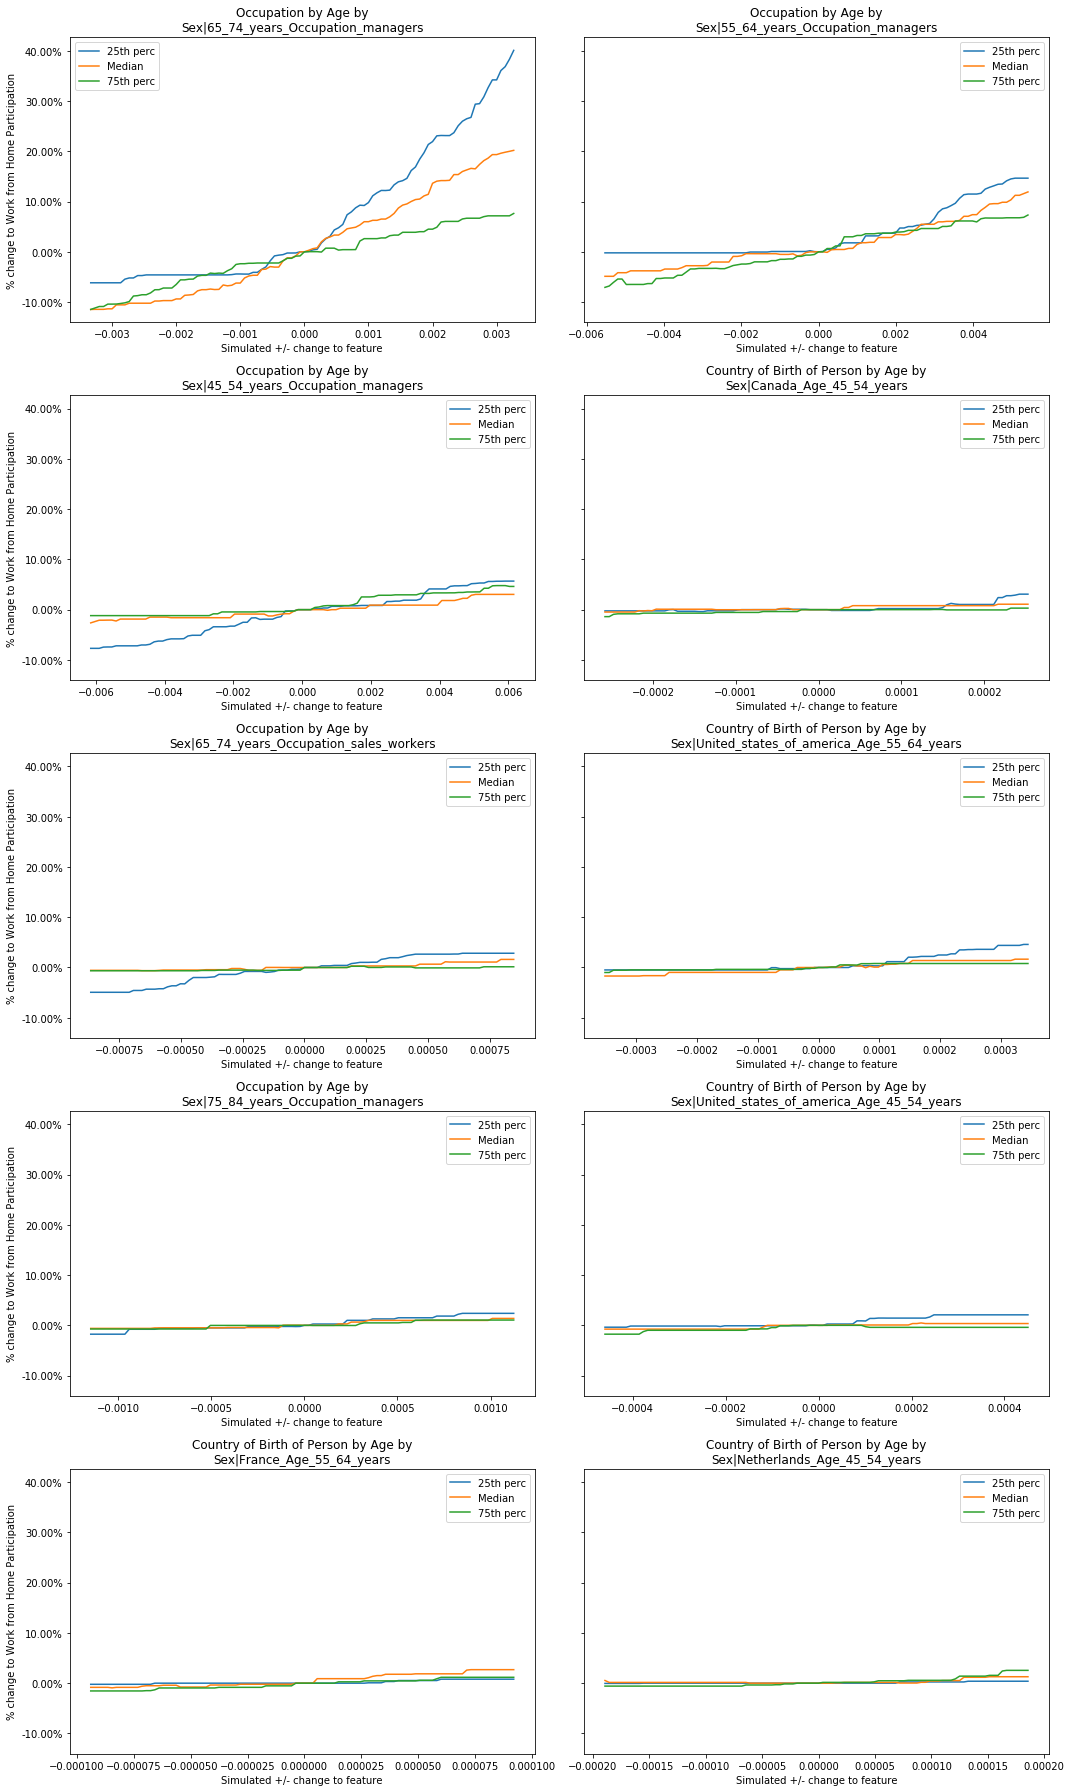

In [128]:
cnss_func.feature_impact_plot(model_sa3_100.steps[1][1], 
                              X_train_sa3_100, 10, 'Work from Home Participation', model_sa3_100)

#### Similar approach for SA2

In [129]:
# Save all the components as reference files so I can quickly refer to these again in the future 
# rather than re-training from scratch
model_sa2_ref, X_train_sa2_ref, X_test_sa2_ref, y_train_sa2_ref, y_test_sa2_ref, X_sa2_ref = model_WFH('SA2')

X_train_sa2_ref.to_csv('{}\X_train_sa3_ref.csv'.format(nb_path))
X_test_sa2_ref.to_csv('{}\X_test_sa3_ref.csv'.format(nb_path))
y_train_sa2_ref.to_csv('{}\y_train_sa3_ref.csv'.format(nb_path))
y_test_sa2_ref.to_csv('{}\y_test_sa3_ref.csv'.format(nb_path))
X_sa2_ref.to_csv('{}\X_sa3_ref.csv'.format(nb_path))
pickle.dump(model_sa2_ref, open('model_sa3_ref.pkl', 'wb'))

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.211, total=   3.3s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.432, total=   3.3s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.368, total=   3.2s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.216, total=   6.0s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.446, total=   6.2s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.371, total=   6.3s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.204, total=   3.2s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.424, total=   3.2s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.366, total=   3.2s
[CV] clf__max_depth=32, clf__n_estimators=40 ...........

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.4min finished
C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  import sys
C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


R2 Score:0.3468794877889714


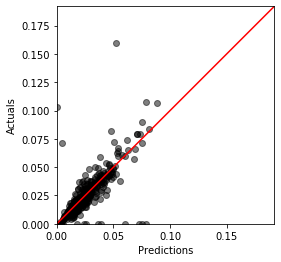

In [135]:
# dropping the two real outlier regions
model_analyse_pred(X_test_sa2_ref.drop([801101137,801101134]), y_test_sa2_ref.drop([801101137,801101134]), model_sa2_ref)

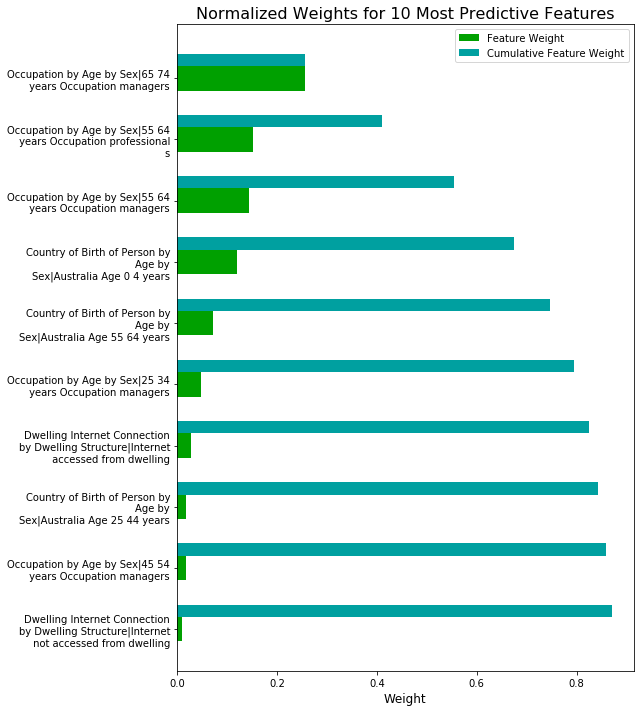

In [131]:
cnss_func.feature_plot_h(model_sa2_ref.steps[1][1], X_train_sa2_ref, 10)

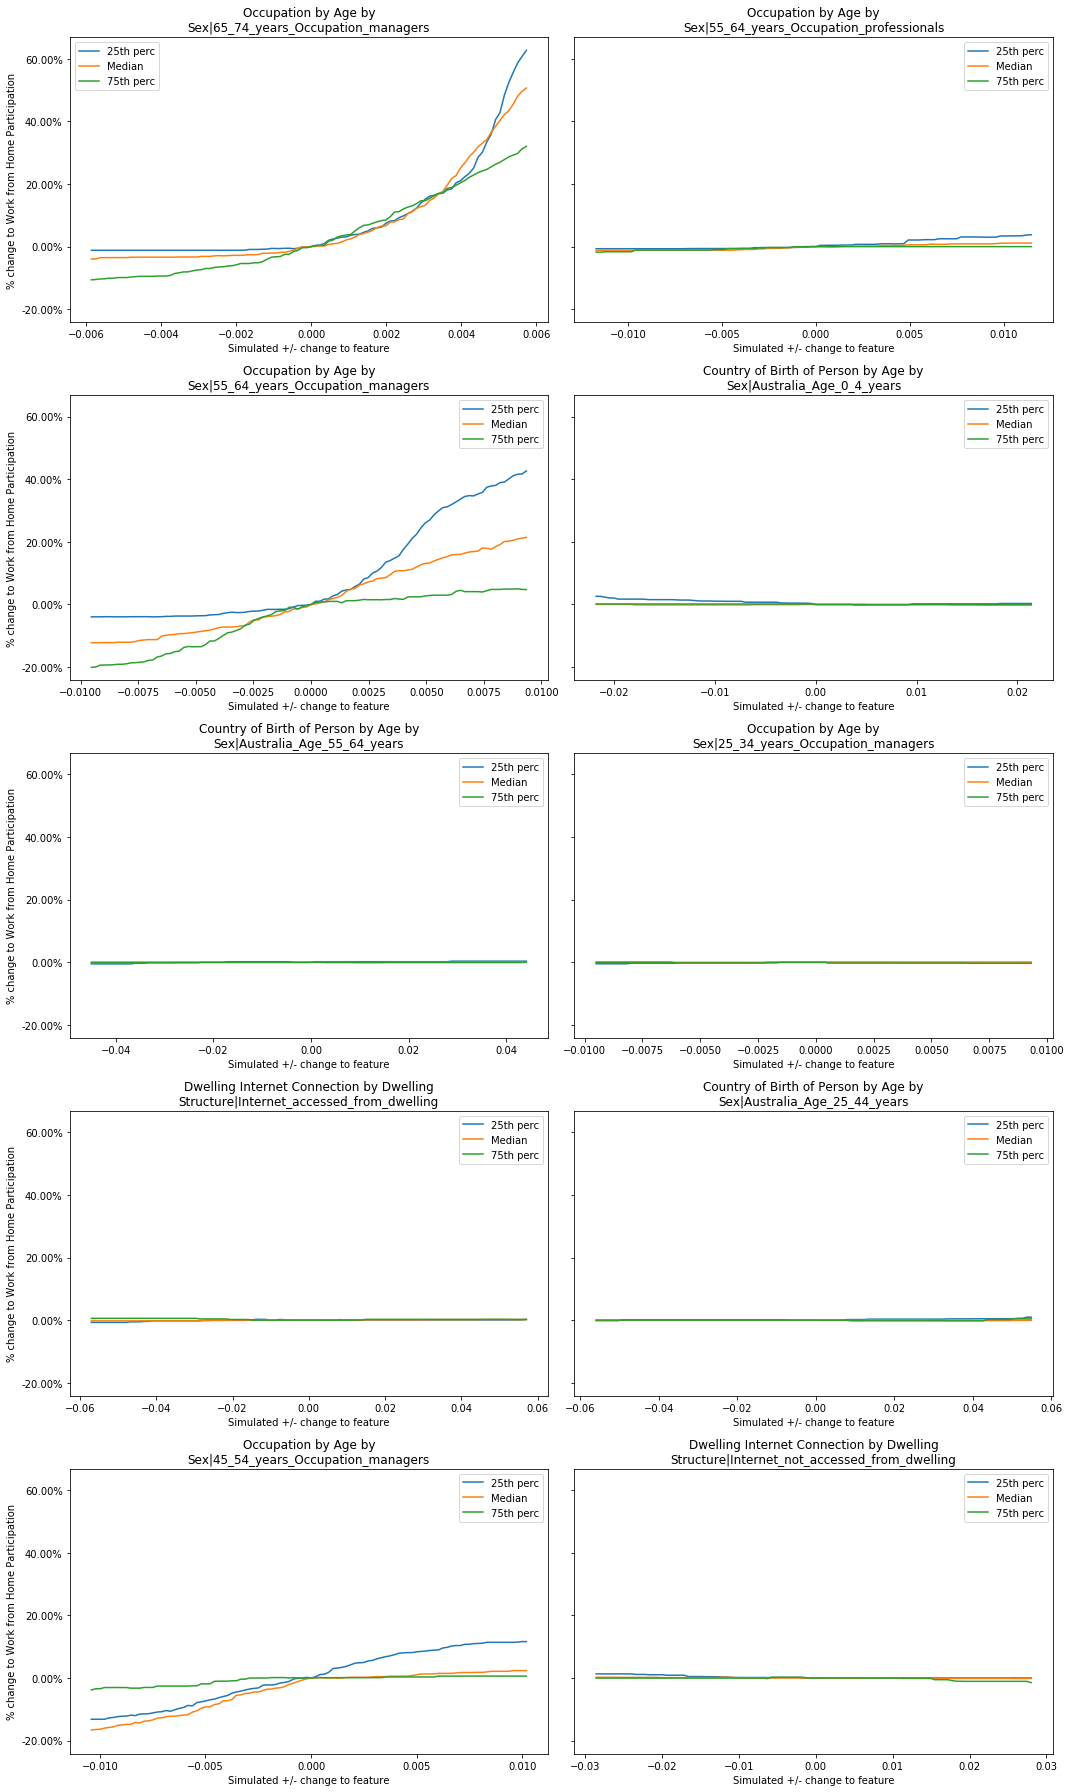

In [132]:
cnss_func.feature_impact_plot(model_sa2_ref.steps[1][1], X_train_sa2_ref, 10, 'Work from Home Participation', model_sa2_ref)

In [133]:
# Reduce feature count to top 100
top_100_feats = cnss_func.top_n_features(model_sa2_ref.steps[1][1], X_train_sa2_ref, 100)

In [142]:
X_sa2_ref.shape

(2255, 571)

In [143]:
df_response_sa2.shape

(2292, 1)

In [144]:
# Create X & y
X_sa2_100 = X_sa2_ref[top_100_feats]
y_sa2 = df_response_sa2.copy().iloc[:,0]

zero_indicies_drop = set(y_sa2.index.values) - set(X_sa2_100.index.values.tolist())
y_sa2 = y_sa2.drop(zero_indicies_drop, axis=0)

# Split the 'features' and 'response' vectors into training and testing sets
# Change random state to avoid weird fitting patterns
X_train_sa2_100, X_test_sa2_100, y_train_sa2_100, y_test_sa2_100 = train_test_split(X_sa2_100, 
                                                                                    y_sa2, 
                                                                                    test_size = 0.2, 
                                                                                    random_state = 42)

# build a model using all the above inputs
grid_obj_sa2_100 = build_model()

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit_sa2_100 = grid_obj_sa2_100.fit(X_train_sa2_100, y_train_sa2_100)
model_sa2_100 = grid_fit_sa2_100.best_estimator_

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.209, total=   1.0s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.461, total=   1.0s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.369, total=   1.0s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.219, total=   1.9s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.465, total=   2.0s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.372, total=   2.1s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.208, total=   1.0s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.453, total=   1.1s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.372, total=   1.0s
[CV] clf__max_depth=32, clf__n_estimators=40 ...........

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   27.5s finished


R2 Score:0.3747642704078846


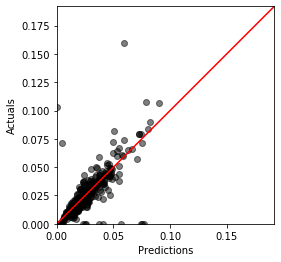

In [148]:
model_analyse_pred(X_test_sa2_100.drop([801101137,801101134]), y_test_sa2_100.drop([801101137,801101134]), model_sa2_100)

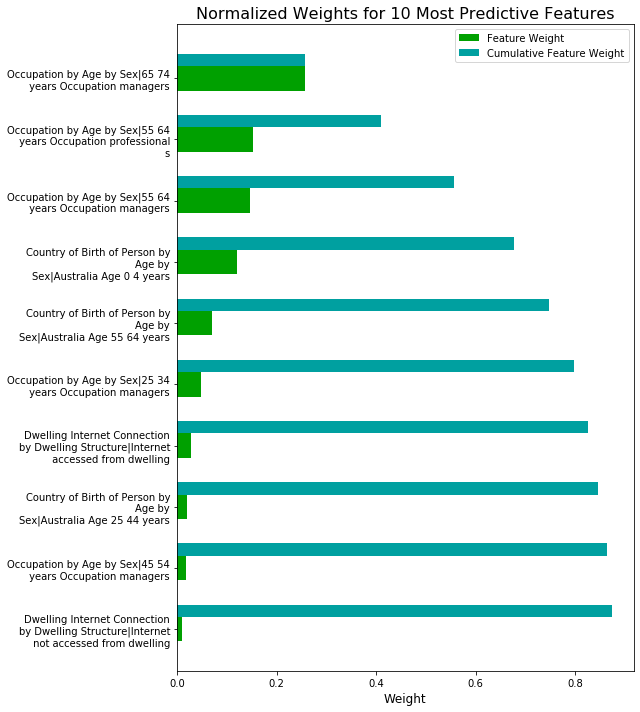

In [146]:
cnss_func.feature_plot_h(model_sa2_100.steps[1][1], X_train_sa2_100, 10)

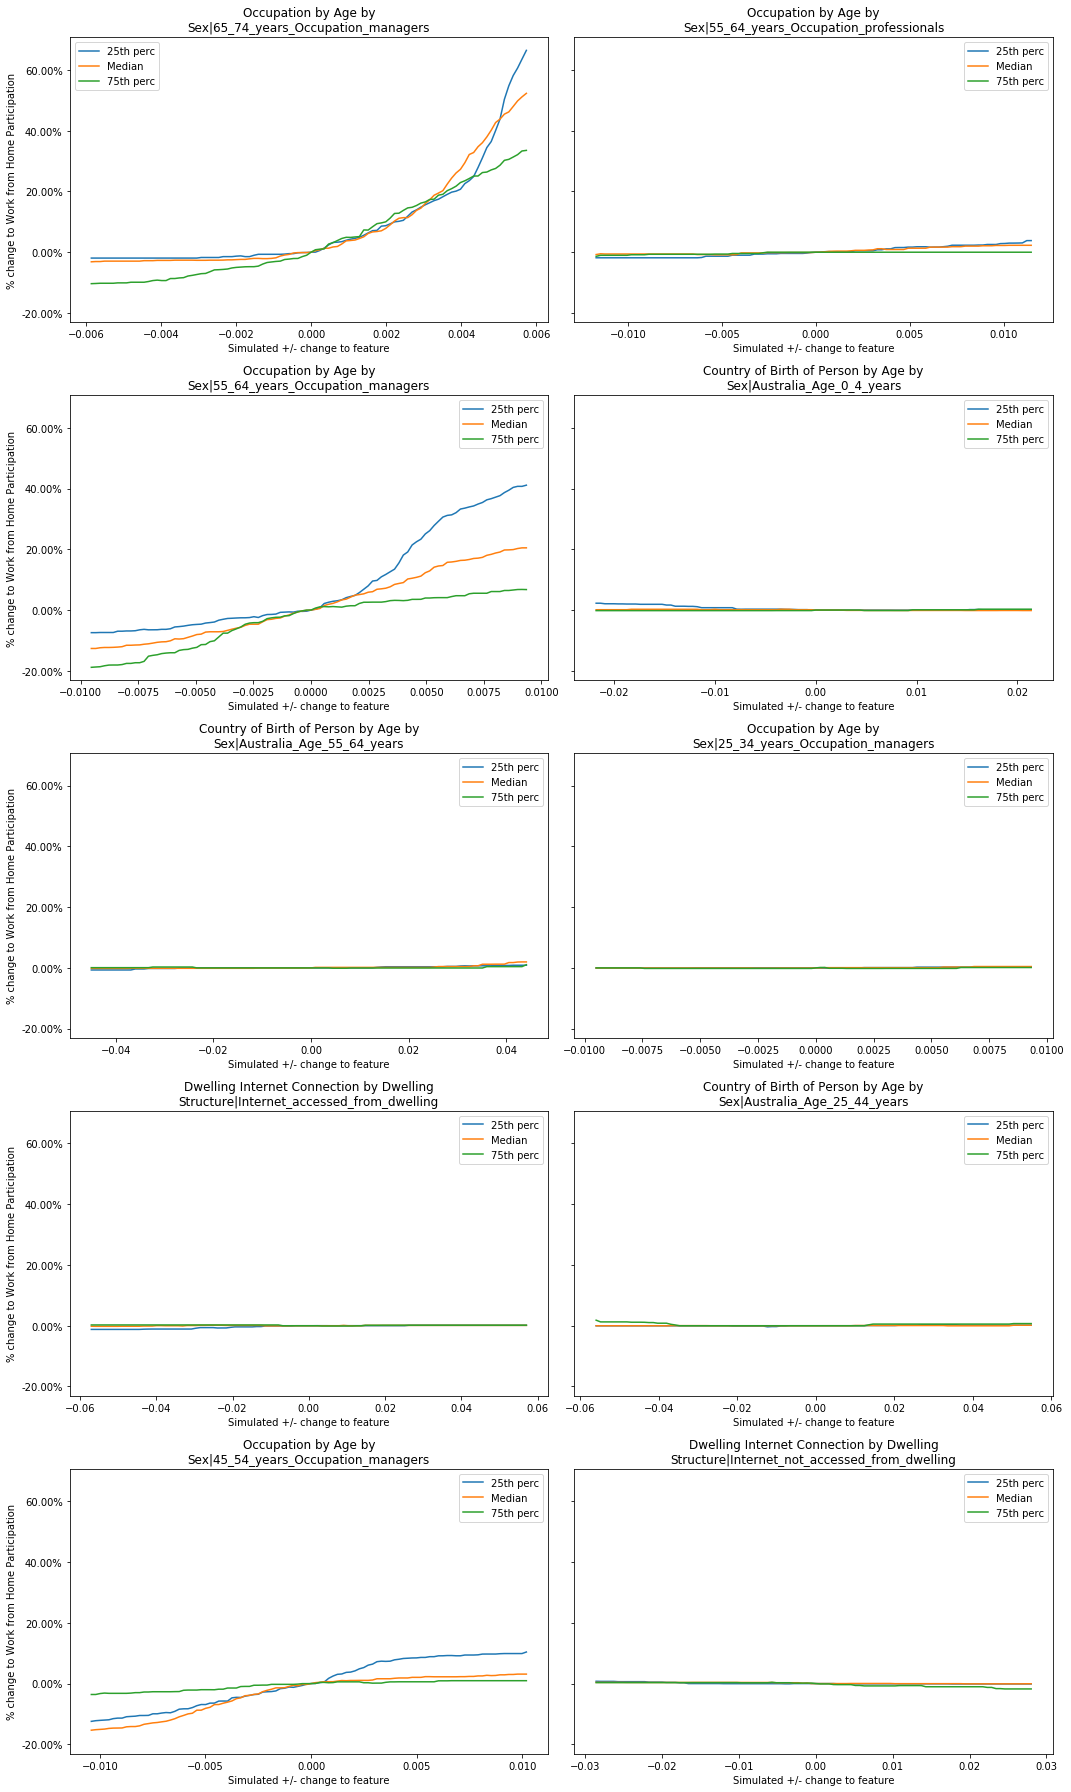

In [147]:
cnss_func.feature_impact_plot(model_sa2_100.steps[1][1], 
                              X_train_sa2_100, 10, 'Work from Home Participation', model_sa2_100)

### What I've learned
Old people love working from home. Or they have more leverage, or some other factor or combination of factors drives an unexpectedly strong response in the Work From Home Participation Rate from the proportion of a given region's population that is >55. 

Really, I'm amazed at just how dominant an Age >55 is as a feature here in terms of its dominance in effect on overall propensity to work from home. From both an SA2 and SA3 level of data, age is the dominant factor in who works from home, especially at the >50 level. So much so that the share of people <45 is also a key feature, having a (slightly) negative correlation even having taken into account the share of the older population! That these factors are more important than the amount of factory line workers in a region or even access to the internet itself is really surprising.

Given the strength of this relationship in the above, I'm curious as to what happens when you remove age from the equation (and also what happens when you add sex in as a feature.

### Modelling excluding Age
The below shows a significant decrease in the efficacy of the model when excluding Age as a population characteristic (but does show some interesting points regarding nationality).

In [39]:
load_tables = ['G57','G55','G37','G33','G34','G09']
load_features = ['Income','Occupation',
                 'Family Composition','Internet status',
                 'Building occupation status','Number of Bedrooms',
                 'Place of Birth','Country of Birth of Parents','Year of Arrival']

model_sa3_ageless, X_train_sa3_ageless, X_test_sa3_ageless, y_train_sa3_ageless, y_test_sa3_ageless = (cnss_func.model_WFH('SA3', 
                                                                                                       load_tables, 
                                                                                                       load_features))

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.811, total=   0.1s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.758, total=   0.1s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.651, total=   0.1s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.825, total=   0.2s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.732, total=   0.2s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.660, total=   0.2s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.0s finished
C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


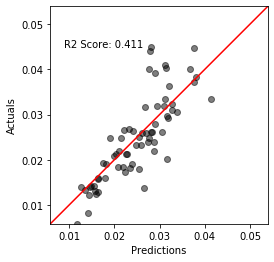

In [40]:
cnss_func.model_analyse_pred(X_test_sa3_ageless, y_test_sa3_ageless, model_sa3_ageless)

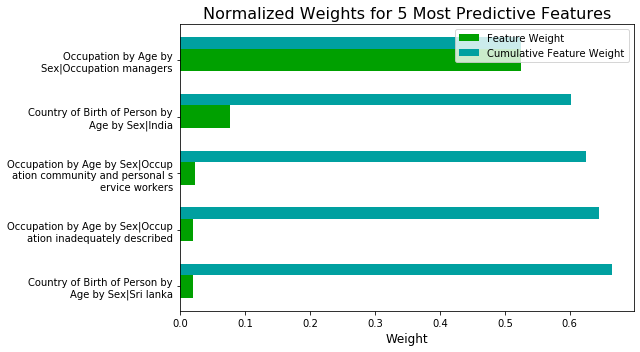

In [41]:
cnss_func.feature_plot_h(model_sa3_ageless.steps[1][1], X_train_sa3_ageless, 5)

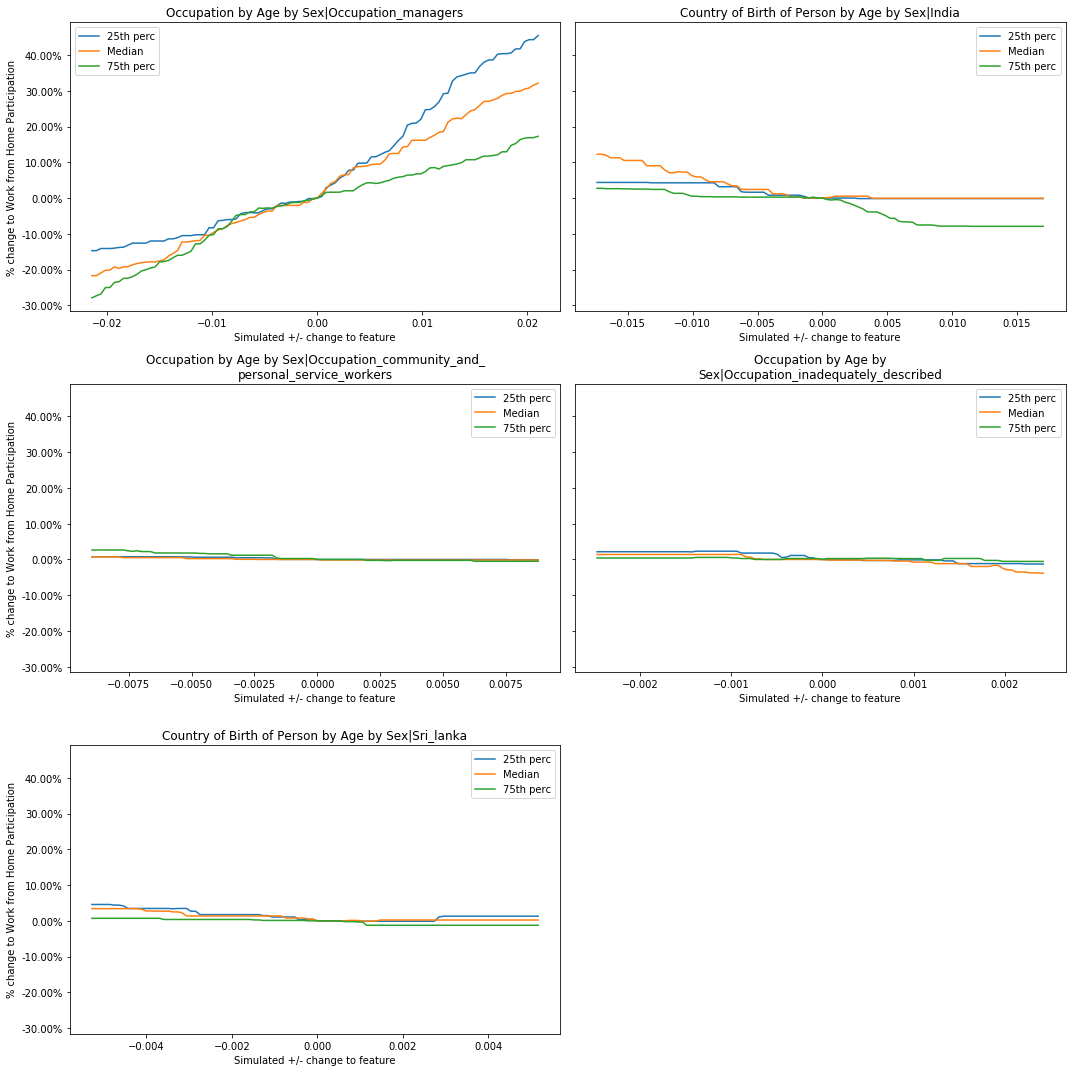

In [43]:
cnss_func.feature_impact_plot(model_sa3_ageless.steps[1][1], 
                              X_train_sa3_ageless, 5, 'Work from Home Participation', model_sa3_ageless)

### Modelling excluding Age but including Sex
Adding Sex into the mix does improve performance, but not nearly to the degree to which including age groups does. It really reinforces the relationship with "Managers", although interestingly does show a much stronger response to Male rather than Female managers.

In [44]:
load_tables = ['G57','G55','G37','G33','G34','G09']
load_features = ['Sex','Income','Occupation',
                 'Family Composition','Internet status',
                 'Building occupation status','Number of Bedrooms',
                 'Place of Birth','Country of Birth of Parents','Year of Arrival']

model_sa3_sex_exA, X_train_sa3_sex_exA, X_test_sa3_sex_exA, y_train_sa3_sex_exA, y_test_sa3_sex_exA = (cnss_func.model_WFH('SA3', 
                                                                                                       load_tables, 
                                                                                                       load_features))

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.829, total=   0.1s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.709, total=   0.2s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.582, total=   0.1s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.833, total=   0.2s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.713, total=   0.2s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.578, total=   0.2s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.829, total=   0.1s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.709, total=   0.1s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.582, total=   0.1s
[CV] clf__max_depth=32, clf__n_estimators=40 .........................
[CV]  clf__max_depth=32, clf__n_estimators=40, score=0.833, total=   0.2s
[CV] clf__max_depth=32, clf__n_estimators=40 ...........

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.2s finished
C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


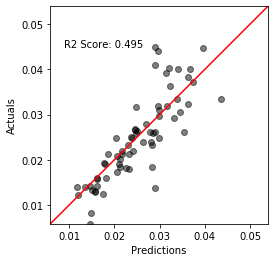

In [45]:
cnss_func.model_analyse_pred(X_test_sa3_sex_exA, y_test_sa3_sex_exA, model_sa3_sex_exA)

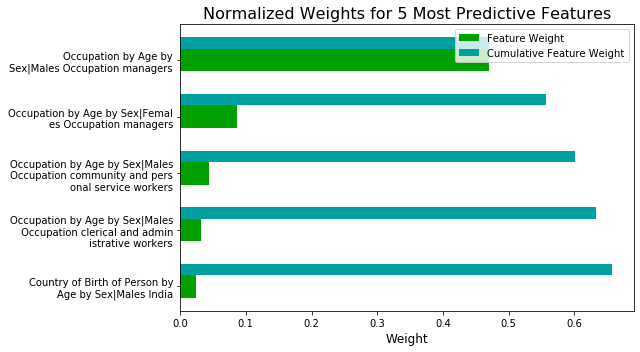

In [46]:
cnss_func.feature_plot_h(model_sa3_sex_exA.steps[1][1], X_train_sa3_sex_exA, 5)

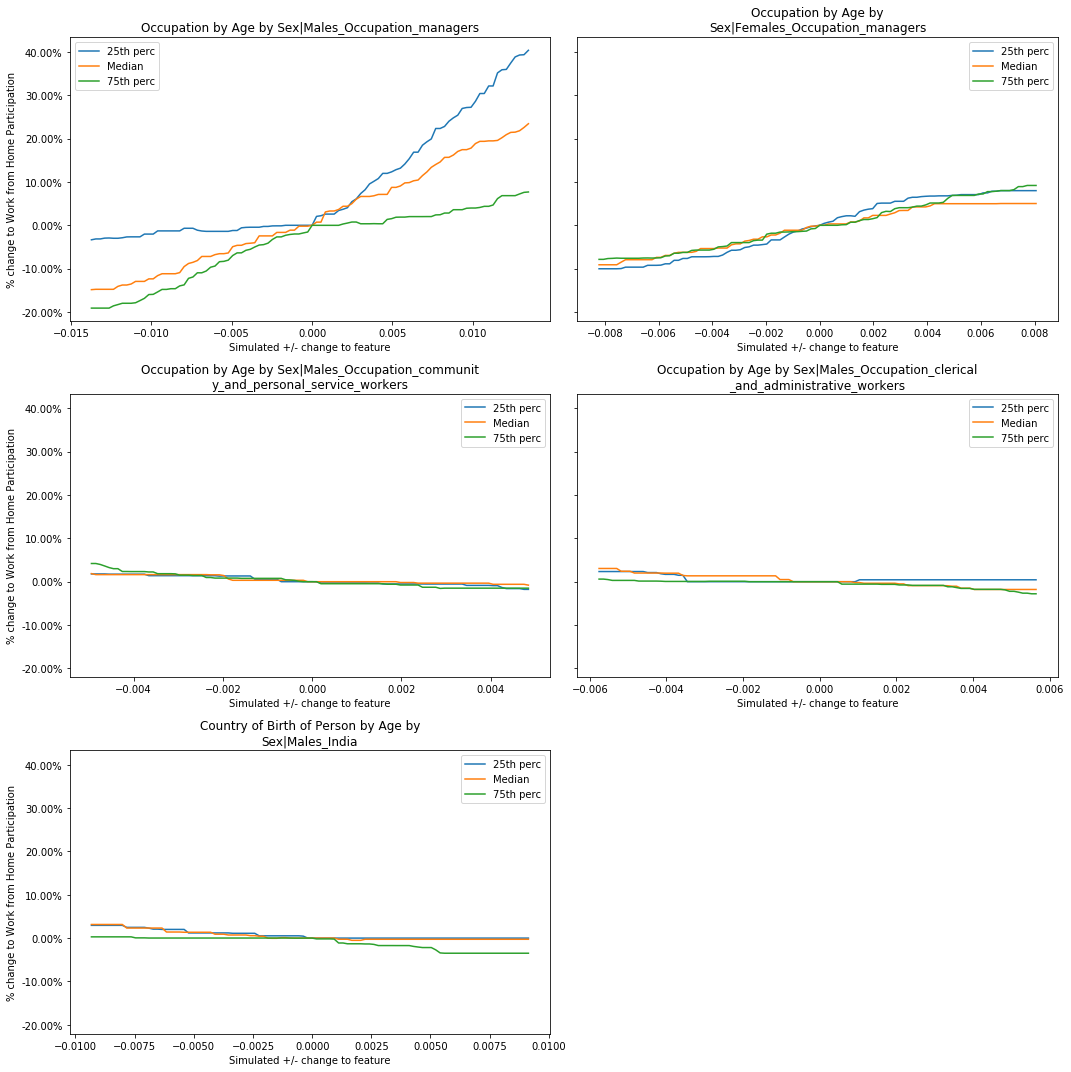

In [47]:
cnss_func.feature_impact_plot(model_sa3_sex_exA.steps[1][1], 
                              X_train_sa3_sex_exA, 5, 'Work from Home Participation', model_sa3_sex_exA)

### For good measure, including both age and sex
Including sex did indeed improve performance vs the base case by roughly 9%, but well within the range of R2 variation I saw in various points of modelling driven simply by changign the random_state parameter in the test_train_split function, so while I'm sure its effect is positive, I'm not going to say its effect is overwhelming. Probably the key insight I saw here is that the only age group with a higher feature importance of Female vs Male populations was in the 45-54 age group. But really, the effects of being in Management is so important it is really the key to working from home (on census day).

In [48]:
load_tables = ['G57','G55','G37','G33','G34','G09']
load_features = ['Age','Sex','Income','Occupation',
                 'Family Composition','Internet status',
                 'Building occupation status','Number of Bedrooms',
                 'Place of Birth','Country of Birth of Parents','Year of Arrival']

model_sa3_sex, X_train_sa3_sex, X_test_sa3_sex, y_train_sa3_sex, y_test_sa3_sex = (cnss_func.model_WFH('SA3', 
                                                                                                       load_tables, 
                                                                                                       load_features))

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__max_depth=16, clf__n_estimators=20 .........................
[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.834, total=   0.6s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.766, total=   0.6s
[CV] clf__max_depth=16, clf__n_estimators=20 .........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV]  clf__max_depth=16, clf__n_estimators=20, score=0.761, total=   0.6s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.854, total=   1.2s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.765, total=   1.1s
[CV] clf__max_depth=16, clf__n_estimators=40 .........................
[CV]  clf__max_depth=16, clf__n_estimators=40, score=0.770, total=   1.2s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.834, total=   0.6s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.766, total=   0.6s
[CV] clf__max_depth=32, clf__n_estimators=20 .........................
[CV]  clf__max_depth=32, clf__n_estimators=20, score=0.761, total=   0.8s
[CV] clf__max_depth=32, clf__n_estimators=40 ...........

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   15.7s finished


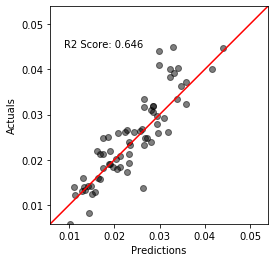

In [49]:
cnss_func.model_analyse_pred(X_test_sa3_sex, y_test_sa3_sex, model_sa3_sex)

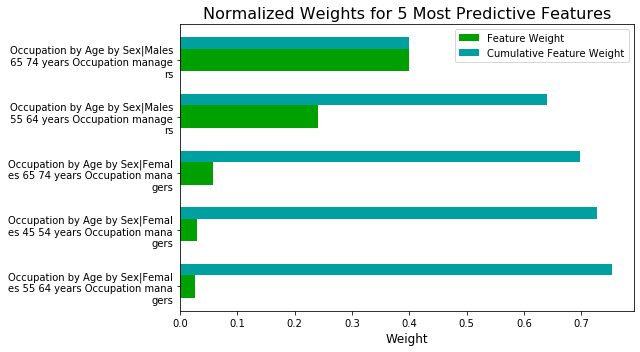

In [50]:
cnss_func.feature_plot_h(model_sa3_sex.steps[1][1], X_train_sa3_sex, 5)

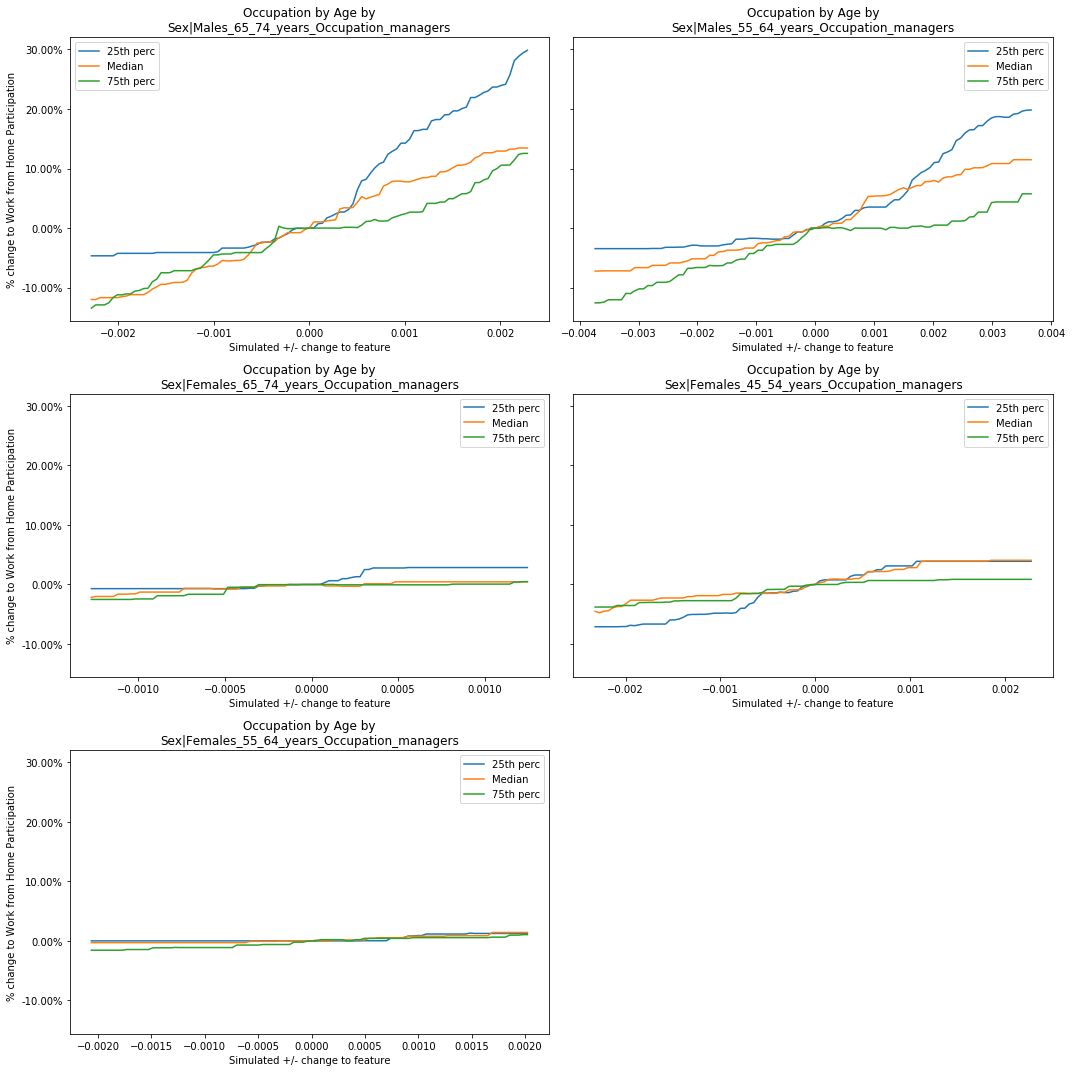

In [51]:
cnss_func.feature_impact_plot(model_sa3_sex.steps[1][1], 
                              X_train_sa3_sex, 5, 'Work from Home Participation', model_sa3_sex)

### Future ideas: Another use of the higher-level data
From the above, the use of SA2 level data was pretty poor at predicting, so as a final output, what happens if we simply assign the work from home participation rate to any SA2 level region to be that of the SA3 region predicted by the much more robust trained SA3 model? E.g. if the SA2 level region is 115039941 then return the prediction for the SA3 region 11503 using the SA3 trained model. Because this is simply prediction participation rates rather than absolute values, the model should be able to handle this fairly well.